# Initialisation

We will begin by importing all the neccessary libraries for generating the desired results in the corresponding report. Note that some libraries will require prior installation before import.

In [ ]:
#install libraries 
!pip install pyts
!pip install pmdarima

#import libraries
import pmdarima as pm
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
from collections import Counter
from pyts.image import GramianAngularField
import time

In [ ]:
#mount drive to obtain data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#path to datafiles
path = '/content/drive/MyDrive/ST456/project/data/'

# Data Cleaning

Given the raw data files, data cleaning is required to reduce the data to a more manageable shape and to slice only the observations that are relevant for our purpose. In our case, we want only the observations pertaining the trading hours for each stock market.

In [ ]:
#create dictionary that stores all dictionaries
bid_dict = {}
ask_dict = {}

#create dictionary to store US data
bid_dict['us'] = {}
ask_dict['us'] = {}

#load data
bid_dict['us']['14_15'] = pd.read_csv(path+'us500/bid/USA500.IDXUSD_Candlestick_10_M_BID_01.01.2014-29.12.2015.csv')
ask_dict['us']['14_15'] = pd.read_csv(path+'us500/ask/USA500.IDXUSD_Candlestick_10_M_ASK_01.01.2014-29.12.2015.csv')
bid_dict['us']['15_18'] = pd.read_csv(path+'us500/bid/USA500.IDXUSD_Candlestick_10_M_BID_30.12.2015-30.12.2018.csv')
ask_dict['us']['15_18'] = pd.read_csv(path+'us500/ask/USA500.IDXUSD_Candlestick_10_M_ASK_30.12.2015-30.12.2018.csv')
bid_dict['us']['18_21'] = pd.read_csv(path+'us500/bid/USA500.IDXUSD_Candlestick_10_M_BID_31.12.2018-31.12.2021.csv')
ask_dict['us']['18_21'] = pd.read_csv(path+'us500/ask/USA500.IDXUSD_Candlestick_10_M_ASK_31.12.2018-31.12.2021.csv')

#create dictionary to store UK data
bid_dict['uk'] = {}
ask_dict['uk'] = {}

#load data
bid_dict['uk']['14_15'] = pd.read_csv(path+'uk100/bid/GBR.IDXGBP_Candlestick_10_M_BID_01.01.2014-29.12.2015.csv')
ask_dict['uk']['14_15'] = pd.read_csv(path+'uk100/ask/GBR.IDXGBP_Candlestick_10_M_ASK_01.01.2014-29.12.2015.csv')
bid_dict['uk']['15_18'] = pd.read_csv(path+'uk100/bid/GBR.IDXGBP_Candlestick_10_M_BID_30.12.2015-30.12.2018.csv')
ask_dict['uk']['15_18'] = pd.read_csv(path+'uk100/ask/GBR.IDXGBP_Candlestick_10_M_ASK_30.12.2015-30.12.2018.csv')
bid_dict['uk']['18_21'] = pd.read_csv(path+'uk100/bid/GBR.IDXGBP_Candlestick_10_M_BID_31.12.2018-31.12.2021.csv')
ask_dict['uk']['18_21'] = pd.read_csv(path+'uk100/ask/GBR.IDXGBP_Candlestick_10_M_ASK_31.12.2018-31.12.2021.csv')

In [ ]:
#create function that cleans the data and returns the market index series
def clean_data(bid_dict, ask_dict, trading_hours):

  #concatenate the rows of datasets
  bid_df = pd.concat([x for x in bid_dict.values()], axis=0)
  ask_df = pd.concat([x for x in ask_dict.values()], axis=0)

  #change column names of each dataframe
  bid_df = bid_df.rename(columns={'Open':'open_bid', 'High':'high_bid', 'Low':'low_bid', 'Close':'close_bid', 'Volume':'vol_bid'})
  ask_df = ask_df.rename(columns={'Open':'open_ask', 'High':'high_ask', 'Low':'low_ask', 'Close':'close_ask', 'Volume':'vol_ask'})

  #merge bid and ask dataframes
  df = bid_df.merge(ask_df)

  #seperate time by unit
  df['gmt_day'] = df['Gmt time'].apply(lambda x: x[6:10]+'.'+x[3:5]+'.'+x[0:2]) #reorder the date format
  df['gmt_minute'] = df['Gmt time'].apply(lambda x: x[11:16])
  df = df.drop(columns=['Gmt time'])


  #create multi level index by the time
  df = df.set_index(['gmt_day', 'gmt_minute'])

  #slice the dataframe by trading hours
  df = df.loc[(slice(None), trading_hours),].sort_index(level=0)


  #identify days where there is no trading
  df['no_trading'] = 0
  for date, block_df in df.groupby(level=0):
    if (block_df['vol_bid'] == 0).all() and (block_df['vol_ask'] == 0).all():
      df.loc[date, 'no_trading'] = 1

  #remove days where no trading occur
  df = df[df['no_trading'] == 0]

  #remove redundant column
  df = df.drop(columns=['no_trading'])

  #obtain one value for bid and ask respectively
  df['bid'] = df[['open_bid', 'high_bid', 'low_bid','close_bid']].mean(axis=1)
  df['ask'] = df[['open_ask', 'high_ask', 'low_ask','close_ask']].mean(axis=1)

  #calculate weighted average in price
  df['price'] = (df['vol_ask'] * df['bid'] + df['vol_bid'] * df['ask']) / (df['vol_bid'] + df['vol_ask'])

  #fill and impute the missing data
  idx = pd.MultiIndex.from_product([df.index.get_level_values(0).unique(), trading_hours], names=['gmt_day', 'gmt_minute'])
  df = df.reindex(idx).interpolate(method='linear')

  #drop any days which still contains a nan
  to_drop = []
  for date, block in df['price'].groupby(level=0):
    if block.isnull().values.any():
      to_drop.append(date) 

  return df['price'].drop(to_drop, level=0)

Since different stock markets have different trading hours, we need to cope for that and extract all the hours that each market is open for.

In [ ]:
#define function that generates a list all the data recording times during trading hours
def trading_hours_gen(first, N):
  to_return = []
  hour = int(first[:2])
  minute = int(first[3])
  for x in range(N):
    if hour < 10:
      to_return.append(f'0{hour}:{minute}0')
    else:
      to_return.append(f'{hour}:{minute}0')
    minute += 1
    minute = minute % 6
    if minute == 0:
      hour += 1
  return to_return

In [ ]:
#generate a list of trading hours and the number of observations each day
trading_hours = {}
us_hours = 40
uk_hours = 52

trading_hours['us'] = trading_hours_gen('14:30', us_hours)
trading_hours['uk'] = trading_hours_gen('08:00', uk_hours)

In [ ]:
#clean all the data and obtain the prices series
price_data = {}

for key in bid_dict:
  price_data[key] = clean_data(bid_dict[key], ask_dict[key], trading_hours[key])

# Data Preprocessing

After cleaning the data, we need to further create objects based off it that will be used for creating and training our models. The following objects are what we want to create:

*   Consecutive 20-day subsequences of Gramian Angular Field images (input for ConvLSTM and DeepConvLSTM model)
*   Absolute within-day return of next day (Outputs)
*   Maximum and minimum values of absolute within-day return 
(to use as input for DeepConvLSTM + Max & Min Model, and to rescale values after normalisation)
*   Subsequences of prices only (input for 1D CNN-LSTM Model)
*   Subsequences of absolute within-day return only (Input for ARIMA model)
*   GAF image for the max & min values for each subsequence (input for DeepConvLSTM + Max & Min Model)

For the items above, we will also want to split them appropriately into training, validation, and testing data. Also, for doing cross-validation later, we will need to do indexing appropriately for that as well.

Now we start by defining functions that we will be using during this stage.




In [ ]:
#define funciton that normalises data
def normalise_value(x, maximum, minimum):
  return (x - minimum) / (maximum - minimum)

#define function that generates output objects
def output_gen(data_series):

  #create 1D array of within day returns (target objects)
  day_returns = []
  for _, block in data_series.groupby(level=0):
    within_day_return = np.log(block[-1]) - np.log(block[0])
    day_returns.append(np.abs(within_day_return))

  #normalise within day returns
  day_returns = pd.Series(day_returns)
  max_day_returns, min_day_returns = max(day_returns), min(day_returns)
  normalised_day_returns = day_returns.apply(normalise_value, args=(max_day_returns, min_day_returns))

  return np.array(normalised_day_returns), max_day_returns, min_day_returns

#define function that returns the normalised prices each day
def normalised_prices(data_series):
  
  normalised_prices = data_series.apply(normalise_value, args=(max(data_series), min(data_series)))
  normalised_day_prices = []
  for _, block in normalised_prices.groupby(level=0):
    normalised_day_prices.append(block)

  return {'price_only': np.array(normalised_day_prices)}

#define function that generates the input objects
def input_gen(data_series):

  #create 2D array that contains all the prices each day
  day_prices = []
  for _, block in data_series.groupby(level=0):
    day_prices.append(block)
  day_prices = np.array(day_prices)
  
  #convert the input data into images with gramian angular field 
  input_data = {'img': [], 'max_min': []}
  gasf = GramianAngularField(sample_range=(0, 1))

  max_list = []
  min_list = []
  for block in day_prices:
    img = gasf.fit_transform(np.array([block]))[0]
    max_list.append(max(block)) #save the max and min values of each block
    min_list.append(min(block))
    input_data['img'].append(img)

  #normalise the max and min values
  max_val = max(max(max_list), max(min_list))
  min_val = min(min(max_list), min(min_list))

  normalised_max_list = [normalise_value(x, max_val, min_val) for x in max_list]
  normalised_min_list = [normalise_value(x, max_val, min_val) for x in min_list]

  for i in range(len(normalised_max_list)):
    input_data['max_min'].append([normalised_max_list[i], normalised_max_list[i]])


  return input_data, day_prices.shape[1], {'max': normalised_max_list, 'min': normalised_min_list}


#create input sequences of consecutive days and target of following day
def seq_gen(inputData, outputData, timestep):
  timestepWithOutput = timestep + 1

  #identify the indices that we want
  indices = range(len(outputData)-timestepWithOutput+1)
  
  #slice the input objects accordingly
  inputSeqs = {}
  for key in inputData:
    inputSeqs[key] = [inputData[key][i:i+timestep] for i in indices]

  #slice output object
  output = [outputData[i+timestep] for i in indices]

  return inputSeqs, output

#split data for 3 sets of training, validation, testing data by chronological order
def index_split(dataLength, approxValidTestShare, batchSize):
  
  #ensure that the value is divisble by both 20 and the batch size
  q = dataLength // 20

  #find indices according to the approximate data split
  numValidTestSamples = []
  total_s = 0
  for s in approxValidTestShare:
    numValidTestSamples.append(int(q * 20 * s))
    total_s += s 

  totalNumTrainingSamples = int(q * 20 * (1-total_s))

  #identify the number of samples for each part of data
  r = 0
  for i in range(len(numValidTestSamples)):
    q = numValidTestSamples[i] // batchSize
    r += numValidTestSamples[i] % batchSize
    numValidTestSamples[i] = q * batchSize
  
  #add any surplus divisible by batch size to training data
  if r // batchSize > 0: 
    totalNumTrainingSamples += (r // batchSize) * batchSize

  toReturn = []

  #create 4 sets of data for cross validation with varying number of training data
  for i in range(3):
    numSamples = [(totalNumTrainingSamples // (batchSize * 3)) * (i + 1) * batchSize]
    numSamples.extend(numValidTestSamples)

    #compile a list of the wanted indices
    indices = []
    x = 0
    for s in numSamples:
      x += s
      indices.append(x)

    toReturn.append(indices)

  return toReturn

#define function that converts gaf for subsequences:
def gaf_transform(seq):
  gasf = GramianAngularField(sample_range=(0, 1))
  return gasf.fit_transform(np.array([seq]))[0]

In [ ]:
#assign parameters and variables
timestep = 20
batch_size = 64
valid_test_split = [0.15, 0.1]

In [ ]:
#create dictionaries to store data and items
X_train = {key:  {'img_only': {}, 'with_scalar': {}, 'price_only': {}, 'return_only': {}} for key in price_data}
X_valid = {key:  {'img_only': {}, 'with_scalar': {}, 'price_only': {}, 'return_only': {}} for key in price_data}
X_test = {key:  {'img_only': {}, 'with_scalar': {}, 'price_only': {}, 'return_only': {}} for key in price_data}
y_train = {key: {} for key in price_data}
y_valid = {key: {} for key in price_data}
y_test = {key: {} for key in price_data}
y_arima = {key: {} for key in price_data}
max_return = {}
min_return = {}
img_dim = {}
index = {}

In [ ]:
#preprocess all the data and store in associated dictionary
for key in price_data:
  outputs, max_return[key], min_return[key] = output_gen(price_data[key]) #generate normalised daily returns (output)
  inputs, img_dim[key], max_min_dict = input_gen(price_data[key]) #generate GAF images and other inputs

  #transform the objects into subsequences over consecutive days
  input_seqs, target_day = seq_gen(inputs, outputs, timestep) 
  max_min_seqs, _ = seq_gen(max_min_dict, outputs, timestep) 

  for max_min_key in max_min_seqs:
    input_seqs[f'{max_min_key}_img'] = [gaf_transform(seq) for seq in max_min_seqs[max_min_key]]

  price_only_seqs, _ = seq_gen(normalised_prices(price_data[key]), outputs, timestep) #generate input subsequences that does not transform into GAF images

  input_returns_only, output_returns_only = seq_gen({'return_only':outputs}, outputs, timestep)
  index[key] = index_split(len(target_day), valid_test_split, batch_size) #determine the indices to split the data

  #loop over the different data splits and store the data 
  
  for i in range(len(index[key])):
    index_1, index_2, index_3 = index[key][i] 
    new_key = f'{i+1}/3'

    #assign output by split
    y_train[key][new_key] = np.array(target_day[:index_1])
    y_valid[key][new_key] = np.array(target_day[index_1:index_2])
    y_test[key][new_key] = np.array(target_day[index_2:index_3])

    #assign image only input by split
    X_train[key]['img_only'][new_key] = np.array(input_seqs['img'][:index_1])
    X_valid[key]['img_only'][new_key] = np.array(input_seqs['img'][index_1:index_2])
    X_test[key]['img_only'][new_key] = np.array(input_seqs['img'][index_2:index_3])

    #assign all inputs by split
    X_train[key]['with_scalar'][new_key] = [np.array(x[:index_1]) for x in input_seqs.values()]
    X_valid[key]['with_scalar'][new_key] = [np.array(x[index_1:index_2]) for x in input_seqs.values()]
    X_test[key]['with_scalar'][new_key] = [np.array(x[index_2:index_3]) for x in input_seqs.values()]

    #assign no GAF and price only input by split
    X_train[key]['price_only'][new_key] = np.array(price_only_seqs['price_only'][:index_1])
    X_valid[key]['price_only'][new_key] = np.array(price_only_seqs['price_only'][index_1:index_2])
    X_test[key]['price_only'][new_key] = np.array(price_only_seqs['price_only'][index_2:index_3])

    #assign within day returns only input by split (append validation into training data)
    X_test[key]['return_only'][new_key] = np.array(input_returns_only['return_only'][index_2:index_3])
    y_arima[key][new_key] = np.array(output_returns_only[index_2:index_3])

Print out descriptive information about the data we will be using

In [ ]:
#extract the exact dates of the data we will use
dates = {}
for key in price_data:
  all_dates = []
  for date, _ in price_data[key].groupby(level=0):
    all_dates.append(date)

  dates[key] = []
  for j in range(3):
    dates[key].append([])
    for i in index[key][j]:
      dates[key][j].append(all_dates[i+timestep])

  for j in range(len(dates[key])):  
    print(f'{key} end dates of training, validation, testing of {j+1}/3-th part of data is {dates[key][j]}')

us end dates of training, validation, testing of 1/3-th part of data is ['2015.10.30', '2016.10.31', '2017.08.03']
us end dates of training, validation, testing of 2/3-th part of data is ['2017.08.03', '2018.08.02', '2019.05.06']
us end dates of training, validation, testing of 3/3-th part of data is ['2019.05.06', '2020.05.01', '2021.01.28']
uk end dates of training, validation, testing of 1/3-th part of data is ['2015.10.30', '2016.11.01', '2017.08.04']
uk end dates of training, validation, testing of 2/3-th part of data is ['2017.08.04', '2018.08.06', '2019.05.08']
uk end dates of training, validation, testing of 3/3-th part of data is ['2019.05.08', '2020.05.06', '2021.02.04']


In [ ]:
#extract the sample sizes of each part of data
for key in price_data:
  for j in range(3):
    to_print = (X_train[key]['img_only'][f'{j+1}/3'].shape[0], X_valid[key]['img_only'][f'{j+1}/3'].shape[0], X_test[key]['img_only'][f'{j+1}/3'].shape[0])
    print(f'Size of {key} training, validation, testing data of {j+1}/3-th part of data is {to_print}')

Size of us training, validation, testing data of 1/3-th part of data is (448, 256, 192)
Size of us training, validation, testing data of 2/3-th part of data is (896, 256, 192)
Size of us training, validation, testing data of 3/3-th part of data is (1344, 256, 192)
Size of uk training, validation, testing data of 1/3-th part of data is (448, 256, 192)
Size of uk training, validation, testing data of 2/3-th part of data is (896, 256, 192)
Size of uk training, validation, testing data of 3/3-th part of data is (1344, 256, 192)


# Training Preparation

After preparing all the data, we want to prepare the other non-data objects that are relevant to defining and training our models

Define relevant custom layers for models

In [ ]:
#custom layer for decoding encoded image back to original scalar
class add_dimension(keras.layers.Layer):
  def __init__(self, name=None, **kwargs):
    super(add_dimension, self).__init__(name=name, **kwargs)

  def call(self, inputs):
    return tf.expand_dims(inputs, axis=-1)

  def compute_output_shape(self, input_shape):
    return input_shape + (1,)

  def get_config(self, **kwargs):
    config = super().get_config()
    return config

Define custom callbacks relevant for training models

In [ ]:
#define callback that resets LSTM state
class reset_LSTM_state(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.model.reset_states()    

#define callback for earlystopping
def earlystopping(patience):
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, min_delta=1e-16, verbose=1, restore_best_weights=True)

Define relevant functions for training & evaluating models

In [ ]:
#define RMSE loss
def RMSE(arr1, arr2):
  return np.sqrt(((arr1 - arr2) ** 2).mean())

#define MSE loss
def MSE(arr1, arr2):
  return RMSE(arr1, arr2) ** 2

#define MAE loss
def MAE(arr1, arr2):
  return np.abs(arr1 - arr2).mean()

#define function that generates all the prediction with test data
def prediction_gen(data, model, batch_size, with_scalar):
  all_prediction = []

  #determine the number of batches in total
  if with_scalar:
    batch_num = data[0].shape[0] // batch_size
  else:
    batch_num = data.shape[0] // batch_size

  for k in range(batch_num):
    if with_scalar:
      data_batch = [x[batch_size*k:batch_size*(k+1)] for x in data]
    else:
      data_batch = data[batch_size*k:batch_size*(k+1)]

    #make prediction for batch
    prediction = model.predict(data_batch, batch_size=batch_size)
    all_prediction.extend(prediction)

  return all_prediction

#define function that rescales the predictions
def rescaling(x, maximum, minimum):
  return ((maximum - minimum) * x) + minimum

#define function that determines the element-wise absolute difference of arrays
def abs_diff(arr1, arr2):
  return np.abs(arr1 - arr2)

In [ ]:
#create dictionaries to store model-related objects
models = {key : {f'{i+1}/3' : {} for i in range(3)} for key in price_data}
model_fits = {key : {f'{i+1}/3' : {} for i in range(3)} for key in price_data}
model_runtimes = {key : {f'{i+1}/3' : {} for i in range(3)} for key in price_data}
model_predictions = {key : {f'{i+1}/3' : {} for i in range(3)} for key in price_data}
model_test = {key : {f'{i+1}/3' : {} for i in range(3)} for key in price_data}

# Descriptive Plots

We want to create some descriptive plots about the dataset before we use it to train our models. This is to have some idea of how the data looks like.

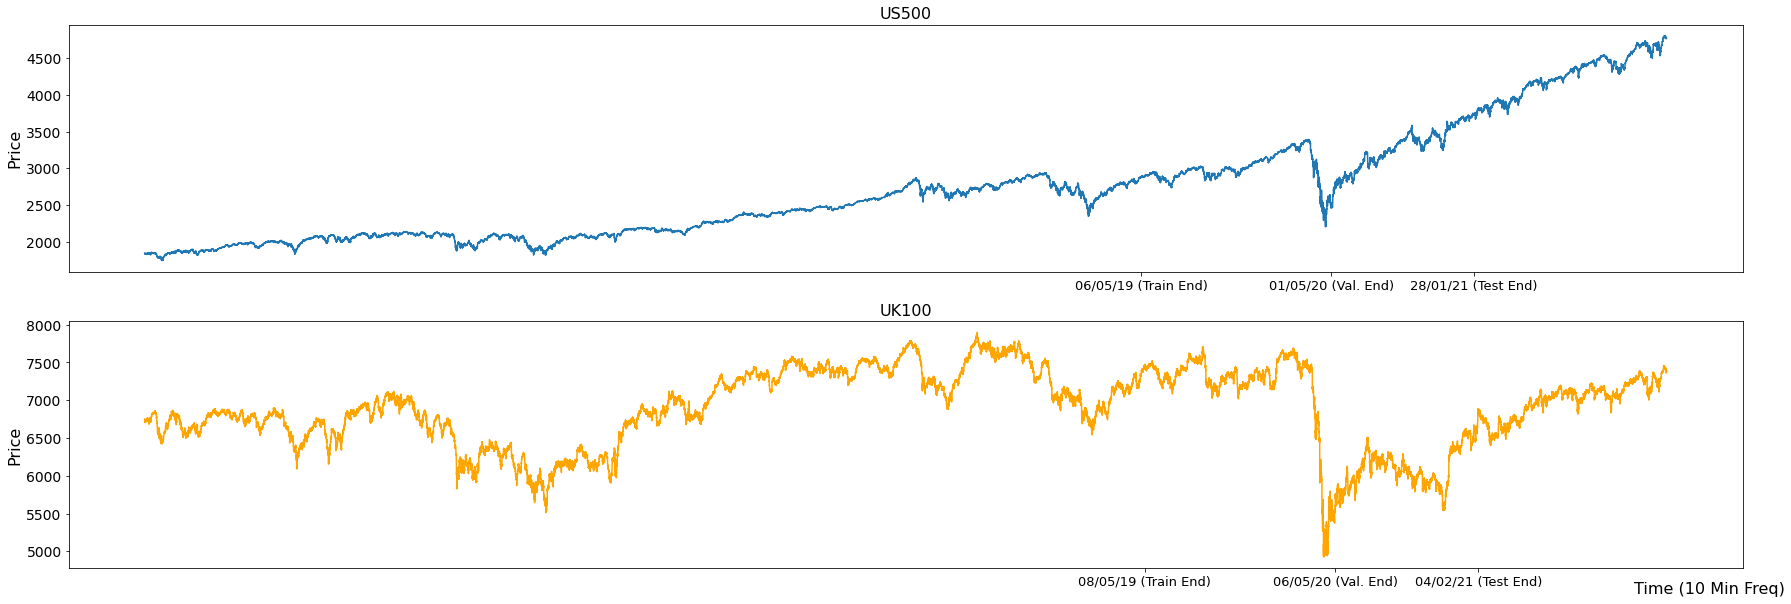

In [ ]:
#plot the full time series of the market index prices
us_xticks = [index['us'][-1][i]*40 for i in range(len(index['us']))]
uk_xticks = [index['uk'][-1][i]*52 for i in range(len(index['uk']))]

#create subplot
fig, ax = plt.subplots(2, 1)

#set output image size
plt.rcParams["figure.figsize"] = (30, 10)

#us data subplot
ax[0].plot(list(price_data['us']))
ax[0].set_title('US500', fontsize=16)
ax[0].set_ylabel('Price', fontsize=16)
plt.sca(ax[0])
plt.xticks(us_xticks, ['06/05/19 (Train End)', '01/05/20 (Val. End)', '28/01/21 (Test End)'], fontsize=13)
plt.yticks(fontsize=14)

#uk data subplot
ax[1].plot(list(price_data['uk']), color='orange')
ax[1].set_title('UK100', fontsize=16)
ax[1].set_ylabel('Price', fontsize=16)
ax[1].set_xlabel('Time (10 Min Freq)', fontsize=16)
ax[1].xaxis.set_label_coords(0.98, -0.055)
plt.sca(ax[1])
plt.xticks(uk_xticks, ['08/05/19 (Train End)', '06/05/20 (Val. End)', '04/02/21 (Test End)'], fontsize=13)
plt.yticks(fontsize=14)



plt.show()

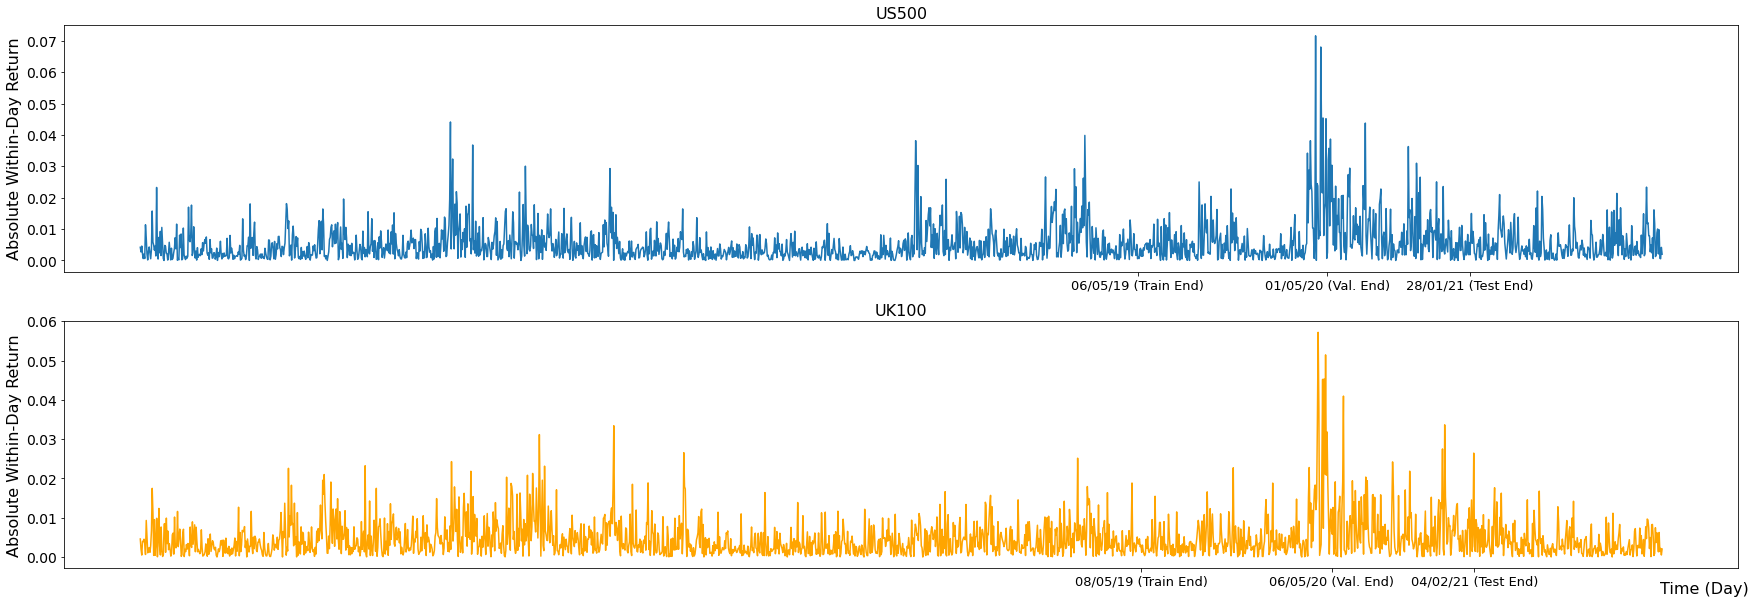

In [ ]:
#plot the full time series of within day returns
us_xticks = [index['us'][-1][i] for i in range(len(index['us']))]
uk_xticks = [index['uk'][-1][i] for i in range(len(index['uk']))]

#identify data
us_returns, us_max, us_min = output_gen(price_data['us'])
uk_returns, uk_max, uk_min = output_gen(price_data['uk'])

us_to_plot = [rescaling(x, us_max, us_min) for x in us_returns]
uk_to_plot = [rescaling(x, uk_max, uk_min) for x in uk_returns]


#create subplot
fig, ax = plt.subplots(2, 1)

#us data subplot
ax[0].plot(us_to_plot)
ax[0].set_title('US500', fontsize=16)
ax[0].set_ylabel('Absolute Within-Day Return', fontsize=16)
plt.sca(ax[0])
plt.xticks(us_xticks, ['06/05/19 (Train End)', '01/05/20 (Val. End)', '28/01/21 (Test End)'], fontsize=13)
plt.yticks(fontsize=14)

#uk data subplot
ax[1].plot((uk_to_plot), color='orange')
ax[1].set_title('UK100', fontsize=16)
ax[1].set_ylabel('Absolute Within-Day Return', fontsize=16)
ax[1].set_xlabel('Time (Day)', fontsize=16)
ax[1].xaxis.set_label_coords(0.98, -0.055)
plt.sca(ax[1])
plt.xticks(uk_xticks, ['08/05/19 (Train End)', '06/05/20 (Val. End)', '04/02/21 (Test End)'], fontsize=13)
plt.yticks(fontsize=14)

plt.show()

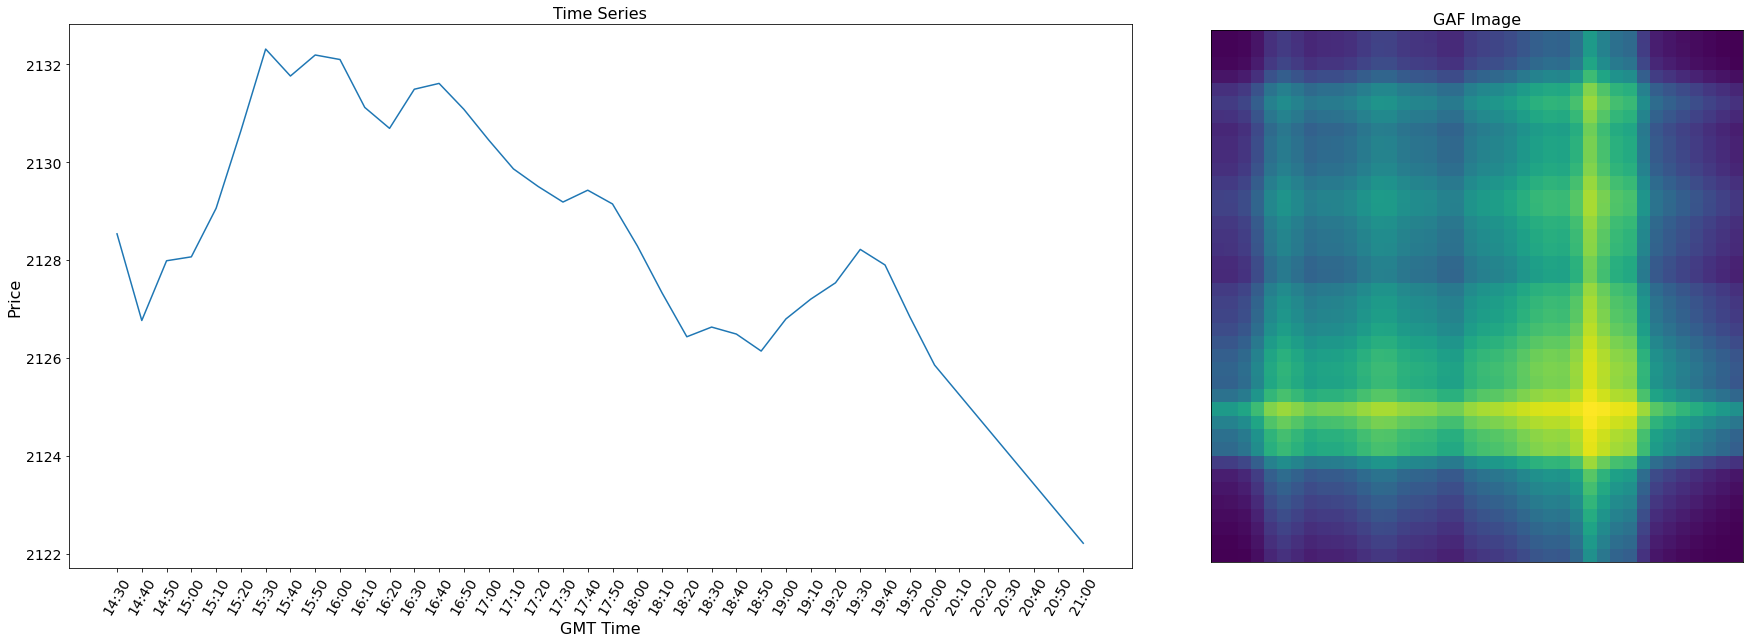

In [ ]:
#display an example of GAF image on 2019 May 6th
example_img = X_valid['us']['img_only']['1/3'][-1][0]
example_prices = price_data['us']['2016.10.31']

gridspec_kw={'width_ratios': [10, 1]}
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax[0].plot(example_prices)
ax[0].set_title('Time Series', fontsize=16)
ax[0].set_ylabel('Price', fontsize=16)
ax[0].set_xlabel('GMT Time', fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=60)


ax[1].imshow(example_img)
ax[1].set_title('GAF Image', fontsize=16)
plt.sca(ax[1])
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(wspace=0.1)

plt.show()

# Model Training (US500 Data)

We start training the models on the US500 data. There will be 5 models that we seek to train, validate, and test on. 


1.   ConvLSTM
2.   DeepConvLSTM
3.   1D CNN-LSTM
4.   ARIMA
5.   DeepConvLSTM + Max-Min Data 


The learning rates and number of epochs were selected appropriately based on previous testing and tuning.

(In the blocks of code that defines the model, we will also define copies of those models which will later be used during cross-validation)



In [ ]:
#set the data of interest to us data
country = 'us'

ConvLSTM Model

This model mimics the one that Hong et. al. (2019) used in their work on time series forecasting using GAF images and ConvLSTM layer too. The choice of most of the number of filters, kernel sizes, placement of batch normalisation, obeys the description of the model the authors created in their paper. Some layers were included at our own discretion to calibrate the model to our absolute within-day return forecasting problem specifically. 

In [ ]:
#define the convlstm model
for i in range(3):
  key = f'{i+1}/3'

  input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
  x = add_dimension(name='img_add_dim')(input)

  x = keras.layers.ConvLSTM2D(filters=16, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              recurrent_activation='sigmoid',
                              data_format='channels_last',
                              stateful=True,
                              name='convlstm2d_3')(x)

  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(filters=16, kernel_size=5, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1)(x)

  models[country][key]['convlstm'] = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_convlstm_model')

  if i + 1 == 3:
    models[country][key]['convlstm'].summary()

Model: "3/3_us_convlstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(64, 20, 40, 40)]        0         
                                                                 
 img_add_dim (add_dimension)  (64, 20, 40, 40, 1)      0         
                                                                 
 convlstm2d_3 (ConvLSTM2D)   (64, 40, 40, 16)          9856      
                                                                 
 batch_normalization_22 (Bat  (64, 40, 40, 16)         64        
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (64, 40, 40, 16)          6416      
                                                                 
 batch_normalization_23 (Bat  (64, 40, 40, 16)         64        
 chNormalization)                            

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 5e-4

train_input = X_train[country]['img_only']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['img_only']['3/3'], y_valid[country]['3/3'])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country][key]['convlstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                         loss=keras.losses.MeanSquaredError(),
                                         metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
model_fits[country]['3/3']['convlstm'] = models[country]['3/3']['convlstm'].fit(x=train_input, 
                                                                                y=train_output, 
                                                                                epochs=N_epoch, 
                                                                                batch_size=batch_size, 
                                                                                verbose=2, 
                                                                                validation_data=valid_data, 
                                                                                shuffle=False,
                                                                                callbacks=[reset_LSTM_state()])

Epoch 1/100
21/21 - 34s - loss: 4.5852 - mean_absolute_error: 1.8109 - root_mean_squared_error: 2.1413 - val_loss: 0.0502 - val_mean_absolute_error: 0.1801 - val_root_mean_squared_error: 0.2241 - 34s/epoch - 2s/step
Epoch 2/100
21/21 - 5s - loss: 0.8951 - mean_absolute_error: 0.7648 - root_mean_squared_error: 0.9461 - val_loss: 0.0775 - val_mean_absolute_error: 0.2406 - val_root_mean_squared_error: 0.2783 - 5s/epoch - 242ms/step
Epoch 3/100
21/21 - 5s - loss: 1.7060 - mean_absolute_error: 1.0874 - root_mean_squared_error: 1.3061 - val_loss: 0.0745 - val_mean_absolute_error: 0.2333 - val_root_mean_squared_error: 0.2729 - 5s/epoch - 243ms/step
Epoch 4/100
21/21 - 5s - loss: 5.1876 - mean_absolute_error: 1.9555 - root_mean_squared_error: 2.2776 - val_loss: 0.0288 - val_mean_absolute_error: 0.1071 - val_root_mean_squared_error: 0.1697 - 5s/epoch - 244ms/step
Epoch 5/100
21/21 - 5s - loss: 7.2513 - mean_absolute_error: 2.3314 - root_mean_squared_error: 2.6928 - val_loss: 0.5502 - val_mean_a

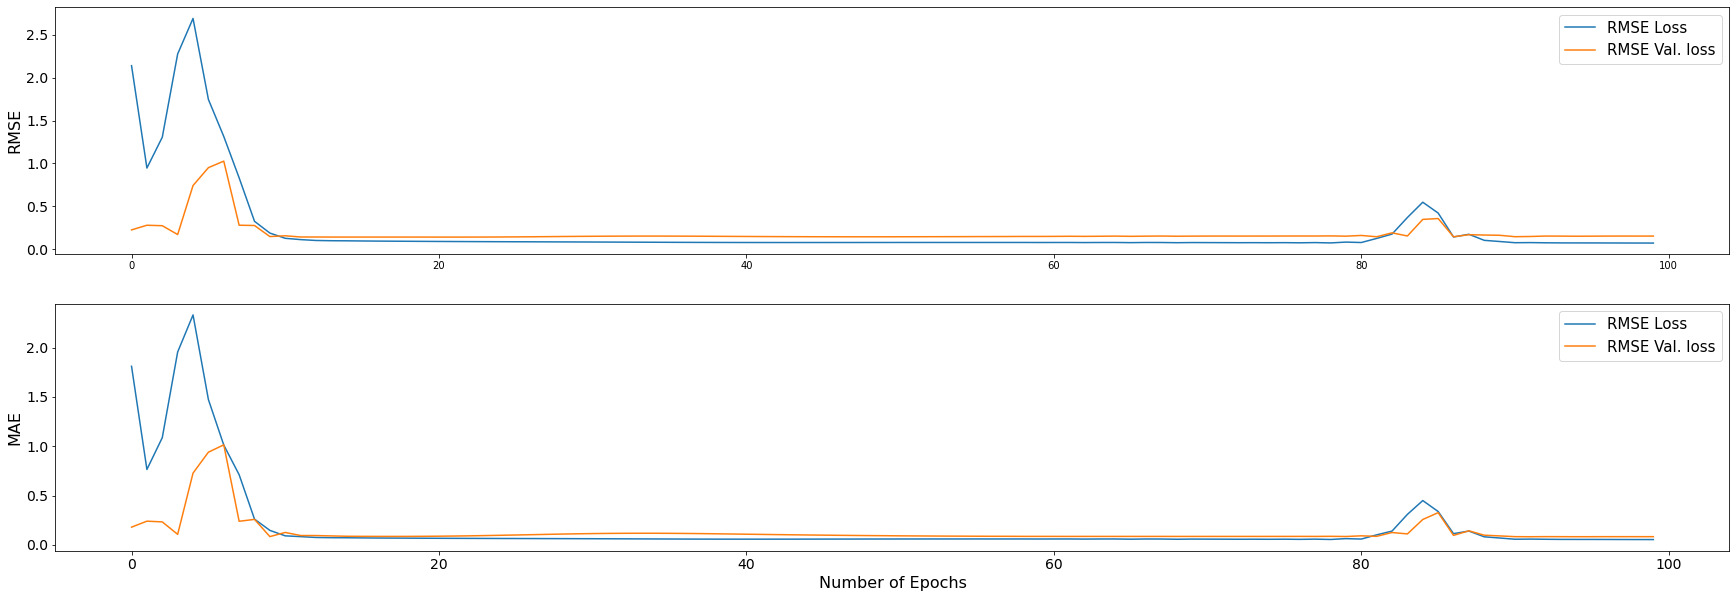

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['convlstm'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['convlstm'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['convlstm'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['convlstm'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['img_only']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['convlstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['convlstm'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.01430929332971573
Test MAE = 0.08015198051929474
Test RMSE = 0.11961076885461808


In [ ]:
#generate predictions
predictions = prediction_gen(test_input, models[country]['3/3']['convlstm'], batch_size, False)
model_predictions[country]['3/3']['convlstm'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]

rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

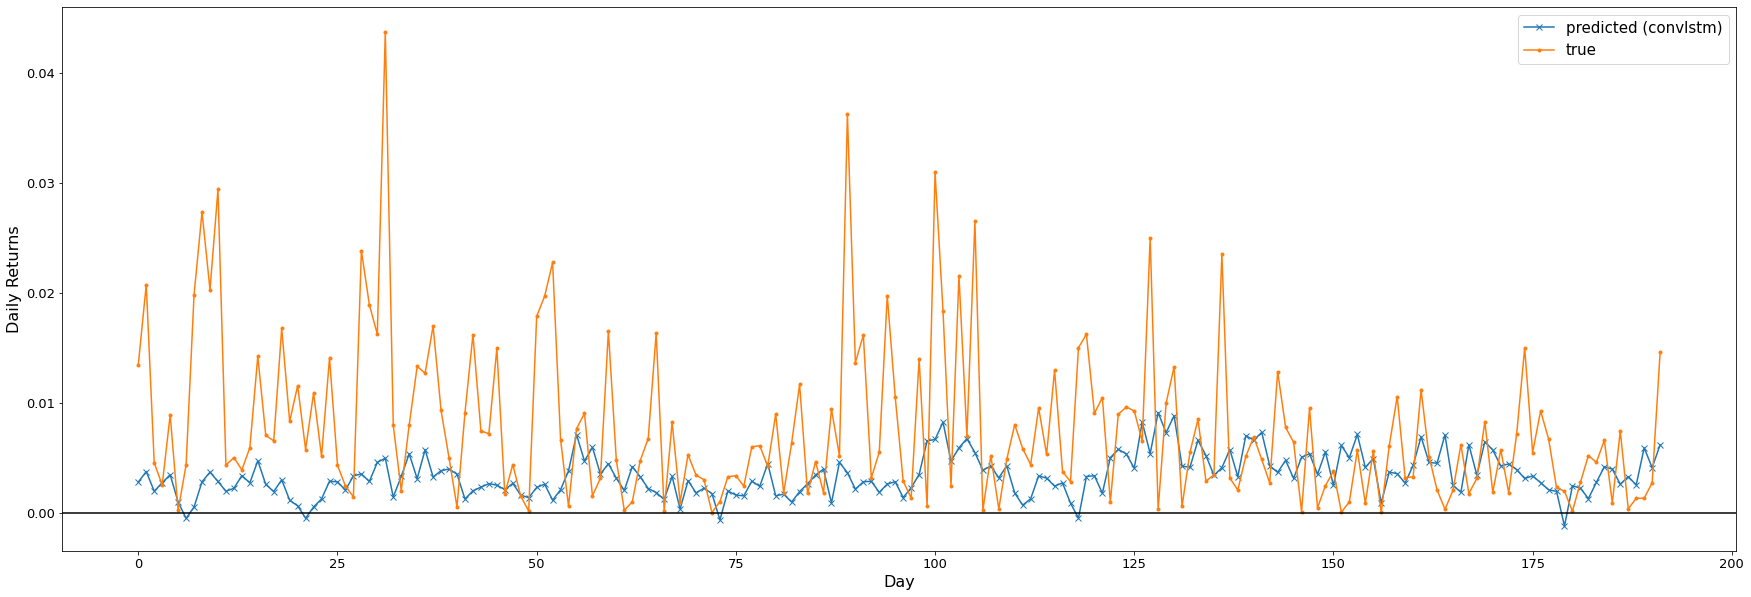

In [ ]:
##plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['convlstm'], label='predicted (convlstm)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks(fontsize=13)
plt.xlabel("Day", fontsize=16)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black')
plt.ylabel("Absolute Within-Day Returns", fontsize=16)
plt.show()

DeepConvLSTM Model

This model is the main model that we are proposing in this report. It stacks multiple blocks of ConvLSTM-CNN netowrks together and incorporates approriate maxpooling between them. To better regularise the model, we do add a dropout layter towards the end of it.

In [ ]:
#define the convlstm-cnn block
def convlstm_cnn_block(filter_num, kernel_num, return_sequence, name):

  model_list = list(range(7))
  
  #case when we want ConvLSTM to return sequence
  if return_sequence:
    model_list[0] = keras.layers.ConvLSTM2D(filters=filter_num, 
                                kernel_size=kernel_num, 
                                strides=1, 
                                padding='same', 
                                recurrent_activation='sigmoid', 
                                data_format='channels_last', 
                                return_sequences=return_sequence, 
                                stateful=True,
                                name='convlstm')
    
    model_list[1] = keras.layers.BatchNormalization(name='batchnorm1')

    model_list[2] = keras.layers.Conv3D(filters=filter_num, kernel_size=kernel_num, padding='same', activation='relu', name='conv1')
    model_list[3] = keras.layers.Conv3D(filters=filter_num, kernel_size=1, padding='same', activation='relu', name='conv2')
    model_list[4] = keras.layers.Conv3D(filters=filter_num, kernel_size=1, padding='same', name='conv3')
    model_list[5] = keras.layers.BatchNormalization(name='batchnorm2')
    model_list[6] = keras.layers.ReLU(name='relu')

  #case when we do not want ConvLSTM to return sequence
  else:
    model_list[0] = keras.layers.ConvLSTM2D(filters=filter_num, 
                                kernel_size=kernel_num, 
                                strides=1, 
                                padding='same', 
                                recurrent_activation='sigmoid', 
                                data_format='channels_last', 
                                return_sequences=return_sequence, 
                                stateful=True,
                                name='convlstm')
    
    model_list[1] = keras.layers.BatchNormalization(name='batchnorm1')

    model_list[2] = keras.layers.Conv2D(filters=filter_num, kernel_size=kernel_num, padding='same', activation='relu', name='conv1')
    model_list[3] = keras.layers.Conv2D(filters=filter_num, kernel_size=1, padding='same', activation='relu', name='conv2')
    model_list[4] = keras.layers.Conv2D(filters=filter_num, kernel_size=1, padding='same', name='conv3')
    model_list[5] = keras.layers.BatchNormalization(name='batchnorm2')
    model_list[6] = keras.layers.ReLU(name='relu')

  return tf.keras.models.Sequential(model_list, name=name)

In [ ]:
#define deep convlstm model (us data)
for i in range(3):
  key = f'{i+1}/3'

  input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
  x = add_dimension(name='img_add_dim')(input)

  x = convlstm_cnn_block(filter_num=4, kernel_num=5, return_sequence=True, name='convlstm_cnn_block1')(x)

  x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling1')(x)

  x = convlstm_cnn_block(filter_num=16, kernel_num=3, return_sequence=True, name='convlstm_cnn_block2')(x)

  x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling2')(x)

  x = convlstm_cnn_block(filter_num=64, kernel_num=3, return_sequence=False, name='convlstm_cnn_block3')(x)

  x = keras.layers.GlobalAveragePooling2D(name='globalaveragepooling')(x)
  x = keras.layers.Dropout(0.8, name='dropout')(x)
  x = keras.layers.Dense(1, name='output')(x)

  models[country][key]['deep_convlstm'] = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_convlstm_deep_model')

  if i + 1 == 3:
    models[country][key]['deep_convlstm'].summary()

Model: "3/3_uk_convlstm_deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(64, 20, 52, 52)]        0         
                                                                 
 img_add_dim (add_dimension)  (64, 20, 52, 52, 1)      0         
                                                                 
 convlstm_cnn_block1 (Sequen  (64, 20, 52, 52, 4)      4092      
 tial)                                                           
                                                                 
 maxpooling1 (MaxPooling3D)  (64, 10, 26, 26, 4)       0         
                                                                 
 convlstm_cnn_block2 (Sequen  (64, 10, 26, 26, 16)     19184     
 tial)                                                           
                                                                 
 maxpooling2 (MaxPooling3D)  (64, 5, 13,

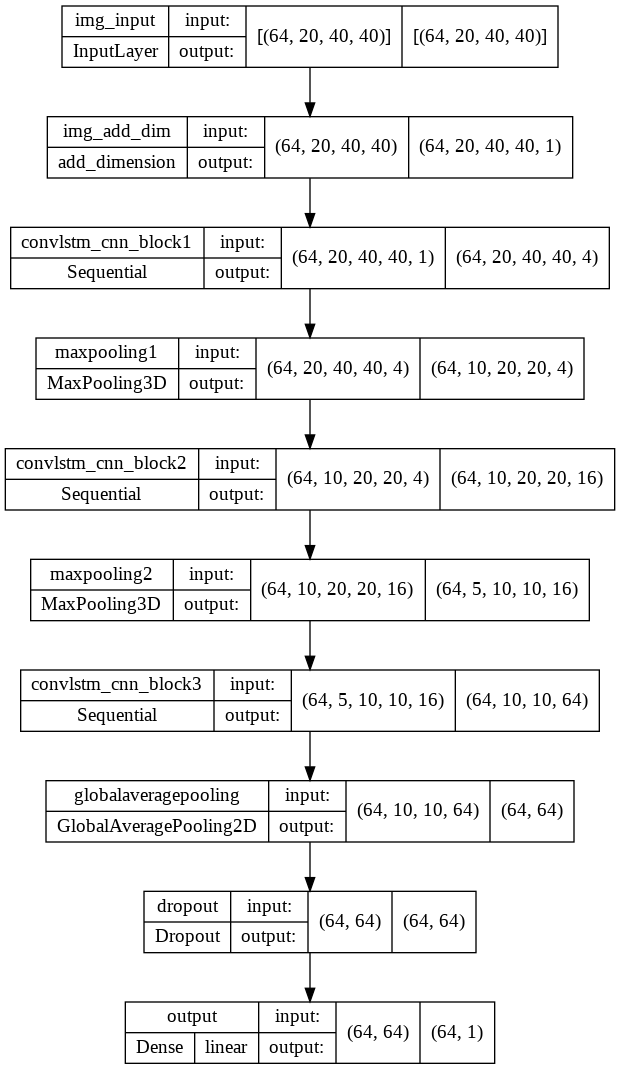

In [ ]:
#display architecture of network
tf.keras.utils.plot_model(models[country][key]['deep_convlstm'], show_shapes=True, show_layer_activations=True)

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 1e-4

train_input = X_train[country]['img_only']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['img_only']['3/3'], y_valid[country]['3/3'])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country]['3/3']['deep_convlstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                                loss=keras.losses.MeanSquaredError(),
                                                metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
model_fits[country]['3/3']['deep_convlstm'] = models[country]['3/3']['deep_convlstm'].fit(x=train_input, 
                                                                                          y=train_output, 
                                                                                          epochs=N_epoch, 
                                                                                          batch_size=batch_size, 
                                                                                          verbose=2, 
                                                                                          validation_data=valid_data, 
                                                                                          shuffle=False,
                                                                                          callbacks=[reset_LSTM_state()])


Epoch 1/100
21/21 - 13s - loss: 1.0190 - mean_absolute_error: 0.8175 - root_mean_squared_error: 1.0094 - val_loss: 0.0330 - val_mean_absolute_error: 0.1038 - val_root_mean_squared_error: 0.1816 - 13s/epoch - 632ms/step
Epoch 2/100
21/21 - 9s - loss: 0.7882 - mean_absolute_error: 0.7036 - root_mean_squared_error: 0.8878 - val_loss: 0.0346 - val_mean_absolute_error: 0.1100 - val_root_mean_squared_error: 0.1861 - 9s/epoch - 424ms/step
Epoch 3/100
21/21 - 9s - loss: 0.6013 - mean_absolute_error: 0.6152 - root_mean_squared_error: 0.7754 - val_loss: 0.0367 - val_mean_absolute_error: 0.1180 - val_root_mean_squared_error: 0.1917 - 9s/epoch - 426ms/step
Epoch 4/100
21/21 - 9s - loss: 0.4611 - mean_absolute_error: 0.5409 - root_mean_squared_error: 0.6791 - val_loss: 0.0391 - val_mean_absolute_error: 0.1267 - val_root_mean_squared_error: 0.1978 - 9s/epoch - 423ms/step
Epoch 5/100
21/21 - 9s - loss: 0.3839 - mean_absolute_error: 0.4944 - root_mean_squared_error: 0.6196 - val_loss: 0.0414 - val_mea

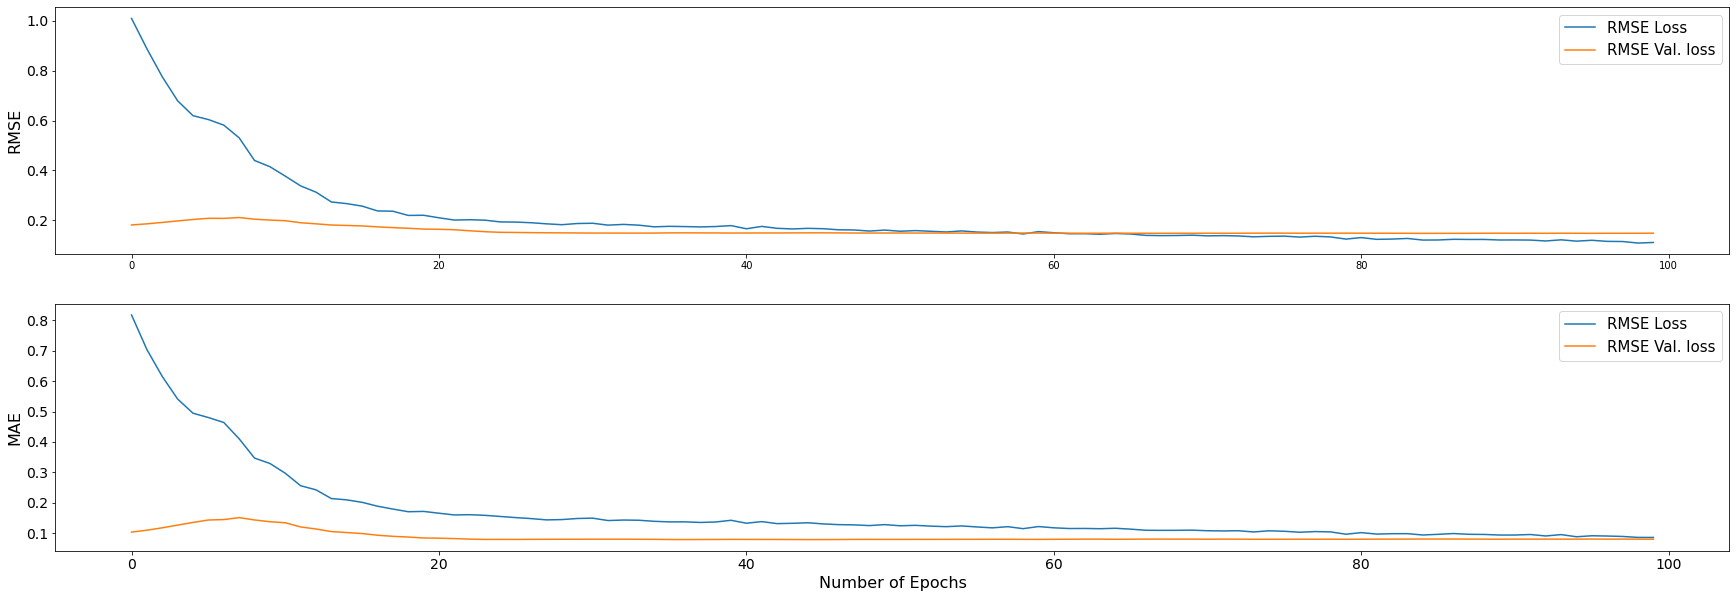

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['deep_convlstm'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['deep_convlstm'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['deep_convlstm'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['deep_convlstm'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['img_only']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['deep_convlstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['deep_convlstm'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.011781043652445079
Test MAE = 0.07544815212488175
Test RMSE = 0.10853979185223579


In [ ]:
#generate predictions
predictions = prediction_gen(test_input, models[country]['3/3']['deep_convlstm'], batch_size, False)
model_predictions[country]['3/3']['deep_convlstm'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

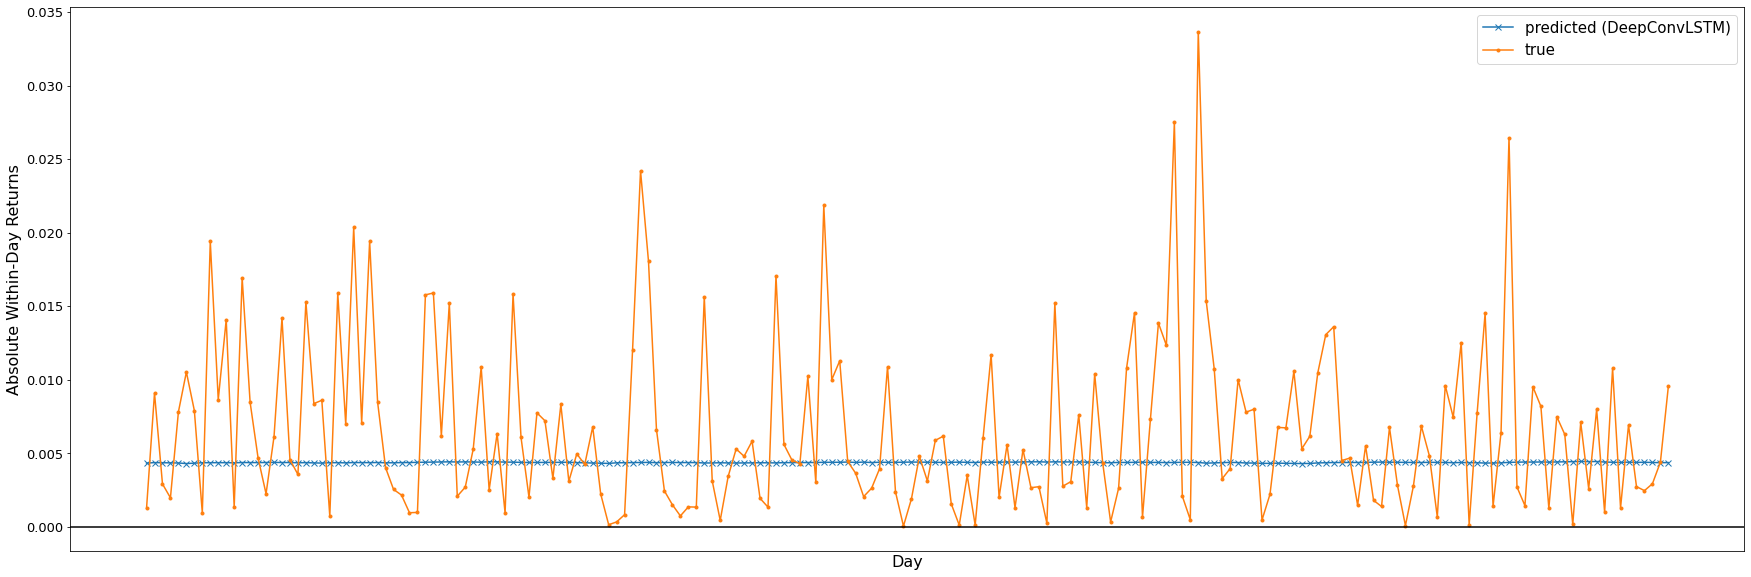

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['deep_convlstm'], label='predicted (DeepConvLSTM)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks([],fontsize=13)
plt.xlabel("Day", fontsize=16)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black')
plt.ylabel("Absolute Within-Day Returns", fontsize=16)
plt.show()

1D CNN-LSTM Model

This model is to serve as a simple benchmark for our other model.



In [ ]:
#define cnn part of model
input = keras.layers.Input(shape=(img_dim[country], ))

x = add_dimension()(input)

x = keras.layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(1, padding='same')(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Flatten()(x)

conv_1d = keras.Model(inputs=input, outputs=x)
conv_1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 add_dimension (add_dimensio  (None, 40, 1)            0         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 40, 16)            32        
                                                                 
 batch_normalization (BatchN  (None, 40, 16)           64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 16)           0         
 )                                                               
                                                             

In [ ]:
#define 1d cnn lstm model
for i in range(3):
  key = f'{i+1}/3'

  input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country]))

  x = keras.layers.TimeDistributed(conv_1d)(input)

  x = keras.layers.LSTM(16, stateful=True)(x)

  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Dense(1)(x)

  models[country][key]['cnn_lstm'] = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_cnn_lstm_model')

  if i + 1 == 3:
    models[country][key]['cnn_lstm'].summary()

Model: "3/3_us_cnn_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(64, 20, 40)]            0         
                                                                 
 time_distributed_14 (TimeDi  (64, 20, 640)            96        
 stributed)                                                      
                                                                 
 lstm_14 (LSTM)              (64, 16)                  42048     
                                                                 
 batch_normalization_15 (Bat  (64, 16)                 64        
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (64, 1)                   17        
                                                                 
Total params: 42,225
Trainable params: 42,161

In [ ]:
#specify training hyperparameter
N_epoch = 10
learn_rate = 5e-4

#specify data for training
train_input = X_train[country]['price_only']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['price_only']['3/3'], y_valid[country]['3/3'])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country]['3/3']['cnn_lstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                           loss=keras.losses.MeanSquaredError(),
                                           metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
start = time.time()
model_fits[country]['3/3']['cnn_lstm'] = models[country]['3/3']['cnn_lstm'].fit(x=train_input, 
                                                                                y=train_output, 
                                                                                epochs=N_epoch, 
                                                                                batch_size=batch_size, 
                                                                                verbose=2, 
                                                                                validation_data=valid_data, 
                                                                                shuffle=False,
                                                                                callbacks=[reset_LSTM_state()])

Epoch 1/10
21/21 - 5s - loss: 0.2752 - mean_absolute_error: 0.3704 - root_mean_squared_error: 0.5246 - val_loss: 0.0478 - val_mean_absolute_error: 0.1824 - val_root_mean_squared_error: 0.2186 - 5s/epoch - 252ms/step
Epoch 2/10
21/21 - 0s - loss: 0.0206 - mean_absolute_error: 0.1123 - root_mean_squared_error: 0.1434 - val_loss: 0.0199 - val_mean_absolute_error: 0.1120 - val_root_mean_squared_error: 0.1410 - 415ms/epoch - 20ms/step
Epoch 3/10
21/21 - 0s - loss: 0.0142 - mean_absolute_error: 0.0886 - root_mean_squared_error: 0.1192 - val_loss: 0.0171 - val_mean_absolute_error: 0.0722 - val_root_mean_squared_error: 0.1309 - 410ms/epoch - 20ms/step
Epoch 4/10
21/21 - 0s - loss: 0.0095 - mean_absolute_error: 0.0692 - root_mean_squared_error: 0.0973 - val_loss: 0.0425 - val_mean_absolute_error: 0.1690 - val_root_mean_squared_error: 0.2061 - 387ms/epoch - 18ms/step
Epoch 5/10
21/21 - 0s - loss: 0.0086 - mean_absolute_error: 0.0655 - root_mean_squared_error: 0.0927 - val_loss: 0.0374 - val_mean

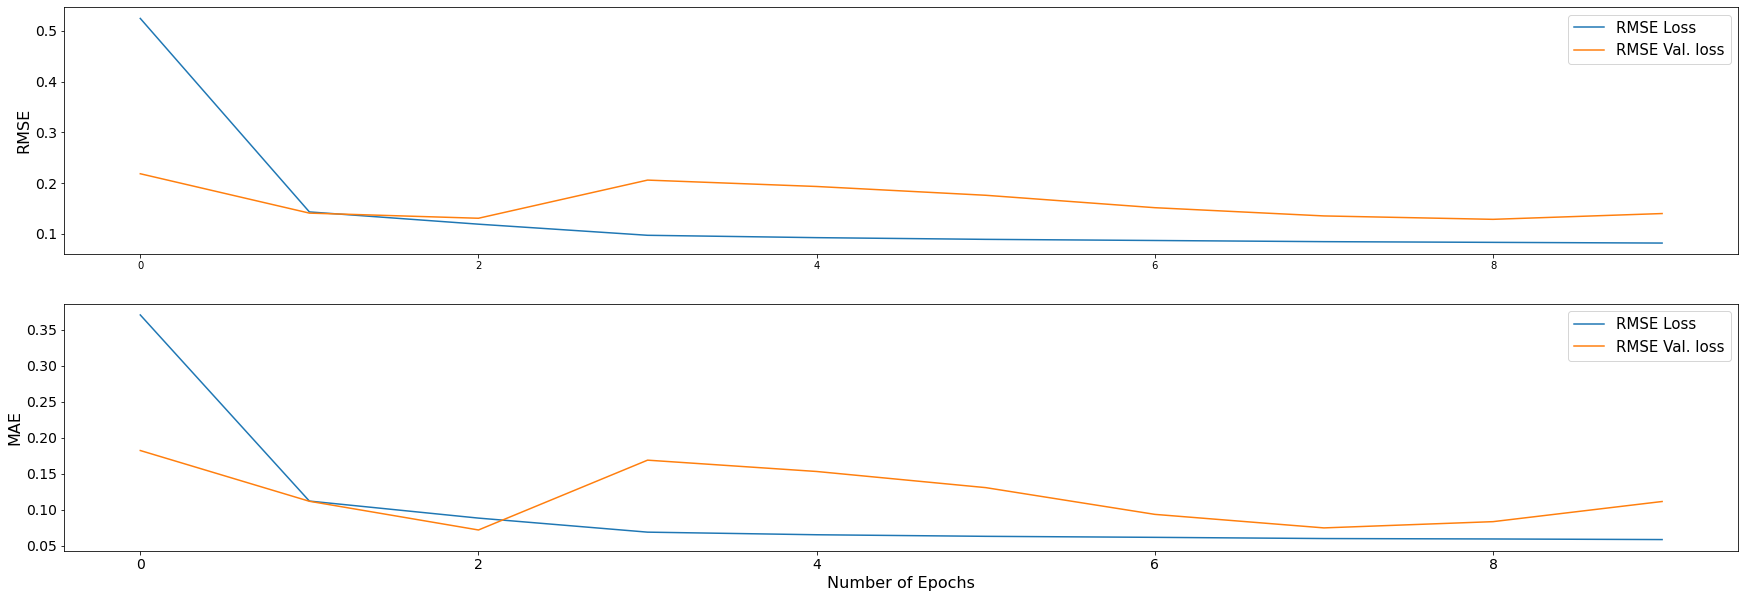

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['cnn_lstm'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['cnn_lstm'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['cnn_lstm'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['cnn_lstm'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['price_only']['3/3']
test_output = y_test[country]['3/3']

#repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['cnn_lstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['cnn_lstm'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.013437006417661905
Test MAE = 0.09929266929626465
Test RMSE = 0.11591808944940567


In [ ]:
#generate predictions
test_input = X_test[country]['price_only']['3/3']
test_output = y_test[country]['3/3']

predictions = prediction_gen(test_input, models[country]['3/3']['cnn_lstm'], batch_size, False)
model_predictions[country]['3/3']['cnn_lstm'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

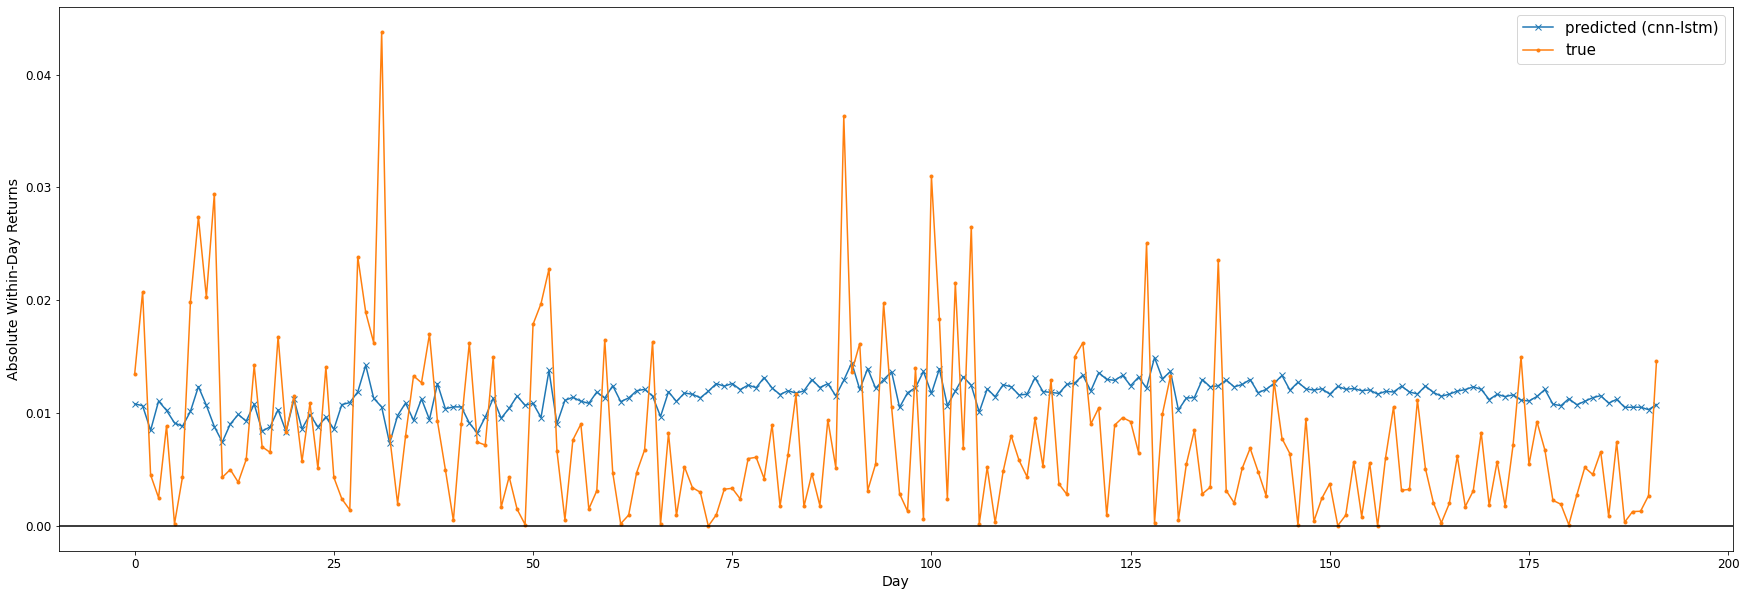

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['cnn_lstm'], label='predicted (cnn-lstm)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks(fontsize=12)
plt.xlabel("Day", fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Absolute Within-Day Returns", fontsize=14)
plt.axhline(y=0, color='black')
plt.rcParams["figure.figsize"] = (30, 10)
plt.show()

ARIMA Model

This model is a benchmark model that uses traditional statistics based techniques.

In [ ]:
#define model using ARIMA with automatically determined parameters p, d, q using past 20 days data
pred = {}
for i in range(3):
  key = f'{i+1}/3'

  arima_test = X_test[country]['return_only'][key]
  pred[key] = []
  for j in range(arima_test.shape[0]):
    temp_model = pm.auto_arima(arima_test[j], error_action='ignore')
    pred[key].append(temp_model.predict(1)) #generate prediction for next day

In [ ]:
#rescale predictions
model_predictions[country]['3/3']['arima'] = [rescaling(x, max_return[country], min_return[country]) for x in pred['3/3']]

#call and rescale true values
true_vals = y_arima[country]['3/3']
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in true_vals]

In [ ]:
#print loss for ARIMA
to_print = [MSE(pred['3/3'], true_vals), MAE(pred['3/3'], true_vals), RMSE(pred['3/3'], true_vals)]
model_test[country]['3/3']['arima'] = [MSE(pred['3/3'], true_vals), MAE(pred['3/3'], true_vals), RMSE(pred['3/3'], true_vals)]

print(f'MSE = {to_print[0]}')
print(f'MAE = {to_print[1]}')
print(f'RMSE = {to_print[2]}')

MSE = 0.012761202652196565
MAE = 0.08621843224057774
RMSE = 0.11296549319237519


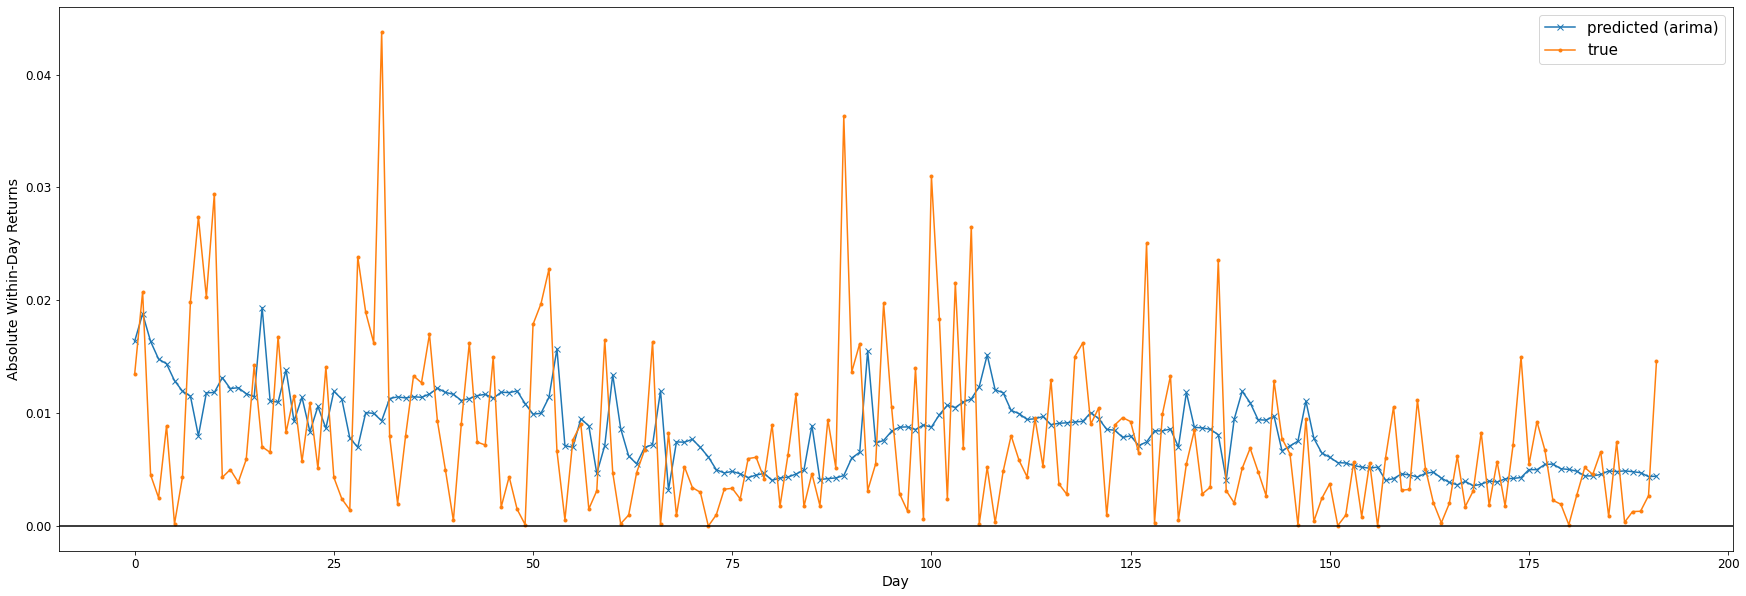

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['arima'], label='predicted (arima)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks(fontsize=12)
plt.xlabel("Day", fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Absolute Within-Day Returns", fontsize=14)
plt.axhline(y=0, color='black')
plt.rcParams["figure.figsize"] = (30, 10)
plt.show()

DeepConvLSTM + Max-Min Model

This model serves to be an extension of the DeepConvLSTM model that we proposed. Aside from the fundemental architecture of DeepConvLSTM, it further incorporates the maximum and minimum values into the network, via an image (CNN) and via just values (LSTM). 

In [ ]:
#define Conv2D netowrk for max and min images
input = keras.layers.Input(shape=(timestep, timestep))

x = add_dimension()(input)

x = keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding='same', activation='relu', name='conv11')(x)
x = keras.layers.Conv2D(filters=4, kernel_size=1, strides=1, padding='same', activation='relu', name='conv12')(x)
x = keras.layers.Conv2D(filters=4, kernel_size=1, strides=1, padding='same', name='conv13')(x)
x = keras.layers.BatchNormalization(name='batchnorm1')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same', name='maxpooling1')(x)
x = keras.layers.ReLU(name='relu1')(x)

x = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv21')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='same', activation='relu', name='conv22')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='same', name='conv23')(x)
x = keras.layers.BatchNormalization(name='batchnorm2')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same', name='maxpooling2')(x)
x = keras.layers.ReLU(name='relu2')(x)

x = keras.layers.Flatten(name='flatten')(x)

conv_2d = keras.Model(inputs=input, outputs=x, name='max_min_img_conv')
conv_2d.summary()

Model: "max_min_img_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 20)]          0         
                                                                 
 add_dimension (add_dimensio  (None, 20, 20, 1)        0         
 n)                                                              
                                                                 
 conv11 (Conv2D)             (None, 20, 20, 4)         104       
                                                                 
 conv12 (Conv2D)             (None, 20, 20, 4)         20        
                                                                 
 conv13 (Conv2D)             (None, 20, 20, 4)         20        
                                                                 
 batchnorm1 (BatchNormalizat  (None, 20, 20, 4)        16        
 ion)                                             

In [ ]:
#define additional parameters
month_dim = 12
max_min_dim = 2


#define main model
for i in range(3):
  key = f'{i+1}/3'

  img_input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
  max_min_input = keras.layers.Input(batch_shape=(batch_size, timestep, max_min_dim, ), name='max_min_input')
  max_img_input = keras.layers.Input(batch_shape=(batch_size, timestep, timestep), name='max_img_input')
  min_img_input = keras.layers.Input(batch_shape=(batch_size, timestep, timestep), name='min_img_input')

  all_inputs = [img_input, max_min_input, max_img_input, min_img_input]
  
  x_img = add_dimension(name='img_add_dim')(img_input)

  x_img = convlstm_cnn_block(filter_num=4, kernel_num=5, return_sequence=True, name='convlstm_cnn_block1')(x_img)

  x_img = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling1')(x_img)

  x_img = convlstm_cnn_block(filter_num=16, kernel_num=3, return_sequence=True, name='convlstm_cnn_block2')(x_img)

  x_img = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling2')(x_img)

  x_img = convlstm_cnn_block(filter_num=64, kernel_num=3, return_sequence=False, name='convlstm_cnn_block3')(x_img)

  x_img = keras.layers.GlobalAveragePooling2D(name='globalaveragepooling')(x_img)

  x_max_min = keras.layers.LSTM(units=16, stateful=True, name='max_min_lstm')(max_min_input)
  x_max_min = keras.layers.BatchNormalization(name='max_min_batchnorm')(x_max_min)

  x_max_img = conv_2d(max_img_input)
  x_min_img = conv_2d(min_img_input)

  x = keras.layers.Concatenate(name='concatenate')([x_img, x_max_min, x_max_img, x_min_img])
  #x = keras.layers.Dense(128, activation='relu', name='fc')(x)
  x = keras.layers.Dropout(0.8, name='dropout')(x)

  x = keras.layers.Dense(1, name='output')(x)

  models[country][key]['convlstm_deep_scalar'] = keras.Model(inputs=all_inputs, outputs=x, name=key+f'_{country}_convlstm_deep_scalar_model')

  if i + 1 == 3:
    models[country][key]['convlstm_deep_scalar'].summary()

Model: "3/3_us_convlstm_deep_scalar_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(64, 20, 40, 40)]   0           []                               
                                                                                                  
 img_add_dim (add_dimension)    (64, 20, 40, 40, 1)  0           ['img_input[0][0]']              
                                                                                                  
 convlstm_cnn_block1 (Sequentia  (64, 20, 40, 40, 4)  4092       ['img_add_dim[0][0]']            
 l)                                                                                               
                                                                                                  
 maxpooling1 (MaxPooling3D)     (64, 10, 20, 20, 4)  0           [

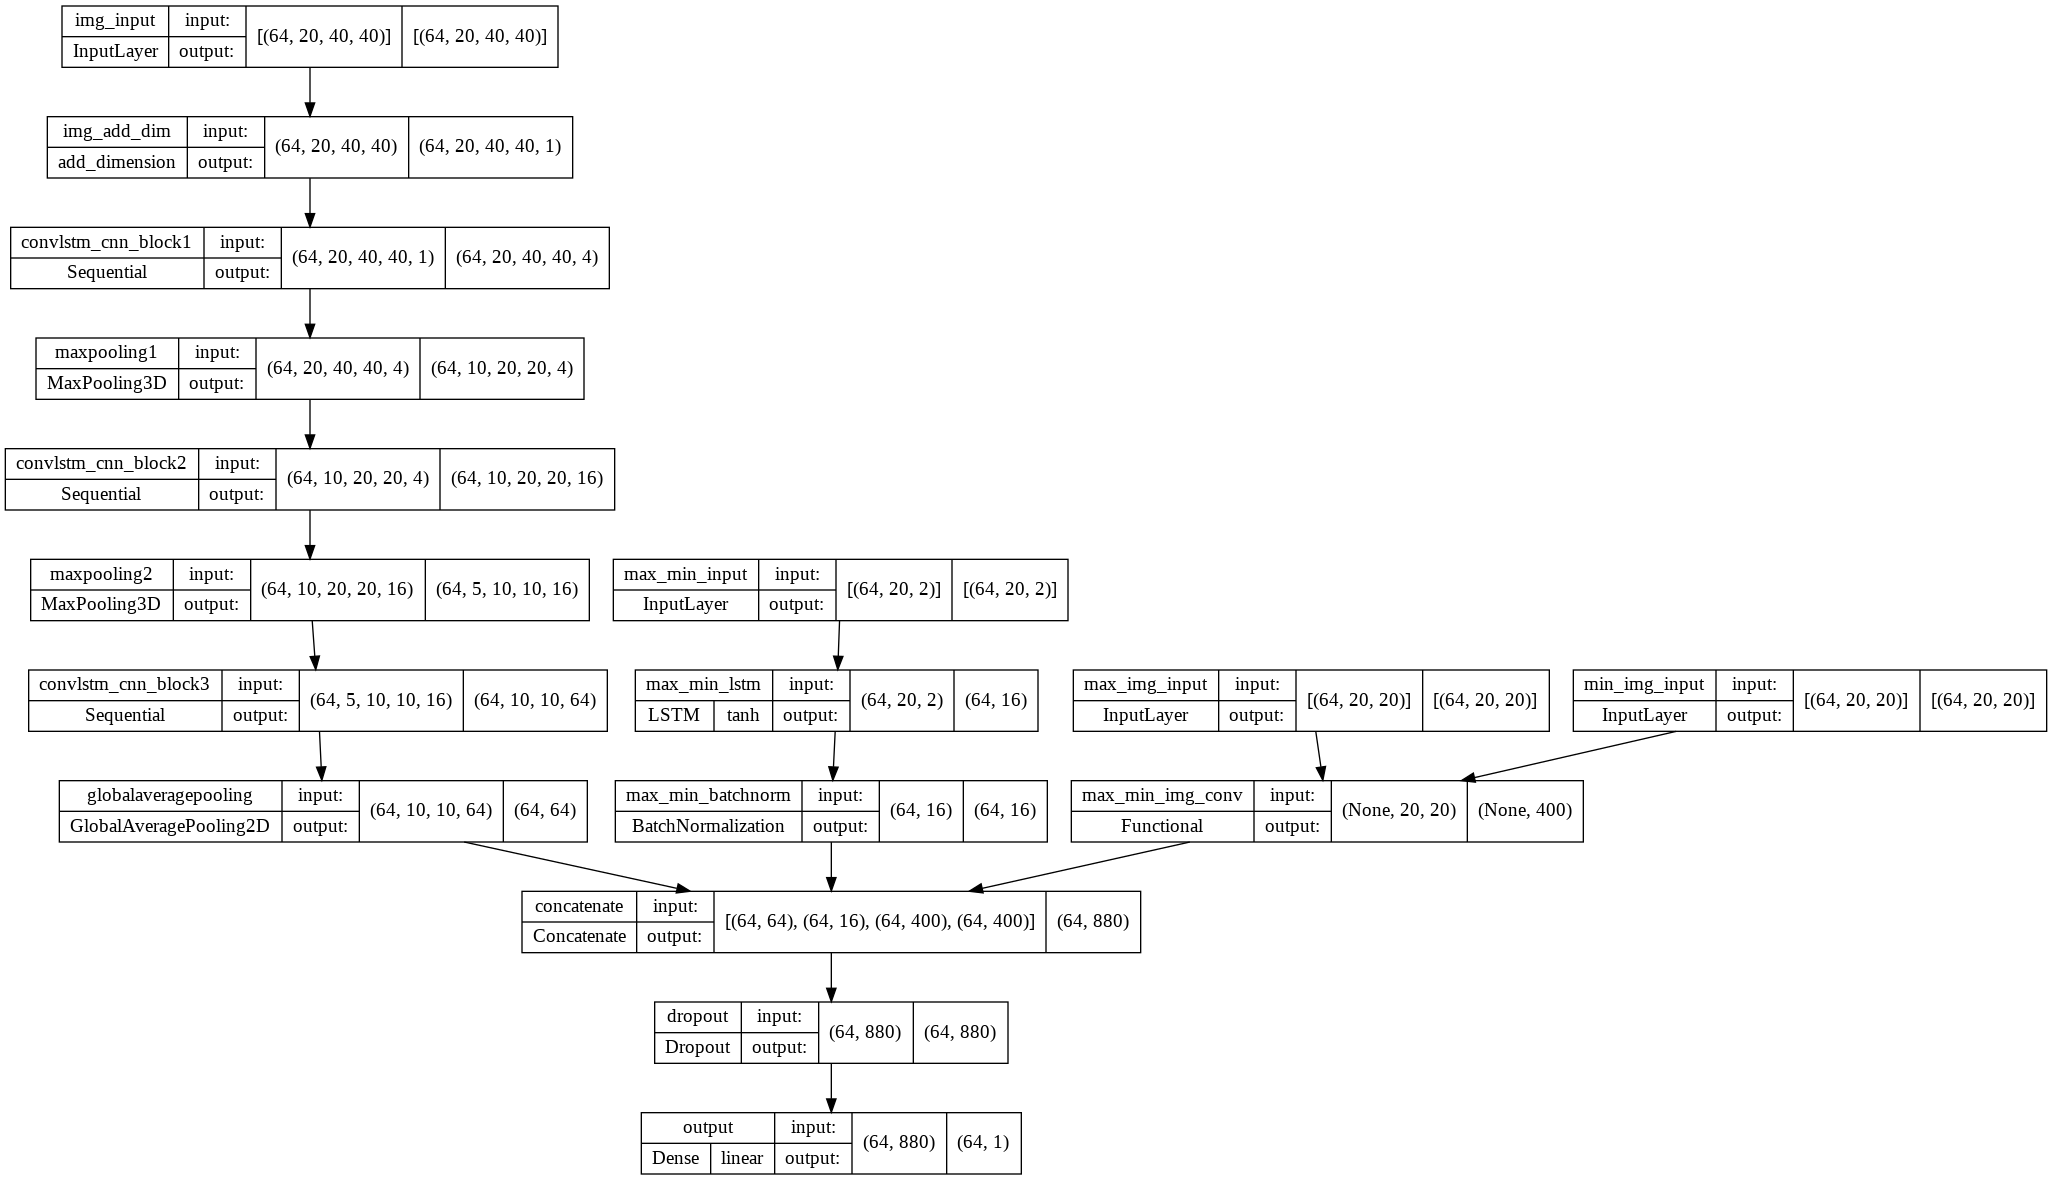

In [ ]:
tf.keras.utils.plot_model(models[country][key]['convlstm_deep_scalar'], show_shapes=True, show_layer_activations=True)

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 3e-4

train_input = X_train[country]['with_scalar']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['with_scalar']['3/3'], y_valid[country]['3/3'])


#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country]['3/3']['convlstm_deep_scalar'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                                       loss=keras.losses.MeanSquaredError(),
                                                       metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
model_fits[country]['3/3']['convlstm_deep_scalar'] = models[country]['3/3']['convlstm_deep_scalar'].fit(x=train_input, 
                                                                                                        y=train_output, 
                                                                                                        epochs=N_epoch, 
                                                                                                        batch_size=batch_size, 
                                                                                                        verbose=2, 
                                                                                                        validation_data=valid_data, 
                                                                                                        shuffle=False,
                                                                                                        callbacks=[reset_LSTM_state()])

Epoch 1/100
21/21 - 17s - loss: 1.8950 - mean_absolute_error: 1.0914 - root_mean_squared_error: 1.3766 - val_loss: 0.0681 - val_mean_absolute_error: 0.1995 - val_root_mean_squared_error: 0.2609 - 17s/epoch - 816ms/step
Epoch 2/100
21/21 - 6s - loss: 1.6047 - mean_absolute_error: 1.0089 - root_mean_squared_error: 1.2668 - val_loss: 0.0549 - val_mean_absolute_error: 0.1703 - val_root_mean_squared_error: 0.2344 - 6s/epoch - 275ms/step
Epoch 3/100
21/21 - 6s - loss: 1.3827 - mean_absolute_error: 0.9482 - root_mean_squared_error: 1.1759 - val_loss: 0.0574 - val_mean_absolute_error: 0.1703 - val_root_mean_squared_error: 0.2396 - 6s/epoch - 268ms/step
Epoch 4/100
21/21 - 6s - loss: 1.2935 - mean_absolute_error: 0.8911 - root_mean_squared_error: 1.1373 - val_loss: 0.0424 - val_mean_absolute_error: 0.1457 - val_root_mean_squared_error: 0.2059 - 6s/epoch - 267ms/step
Epoch 5/100
21/21 - 6s - loss: 1.0863 - mean_absolute_error: 0.8289 - root_mean_squared_error: 1.0422 - val_loss: 0.0463 - val_mea

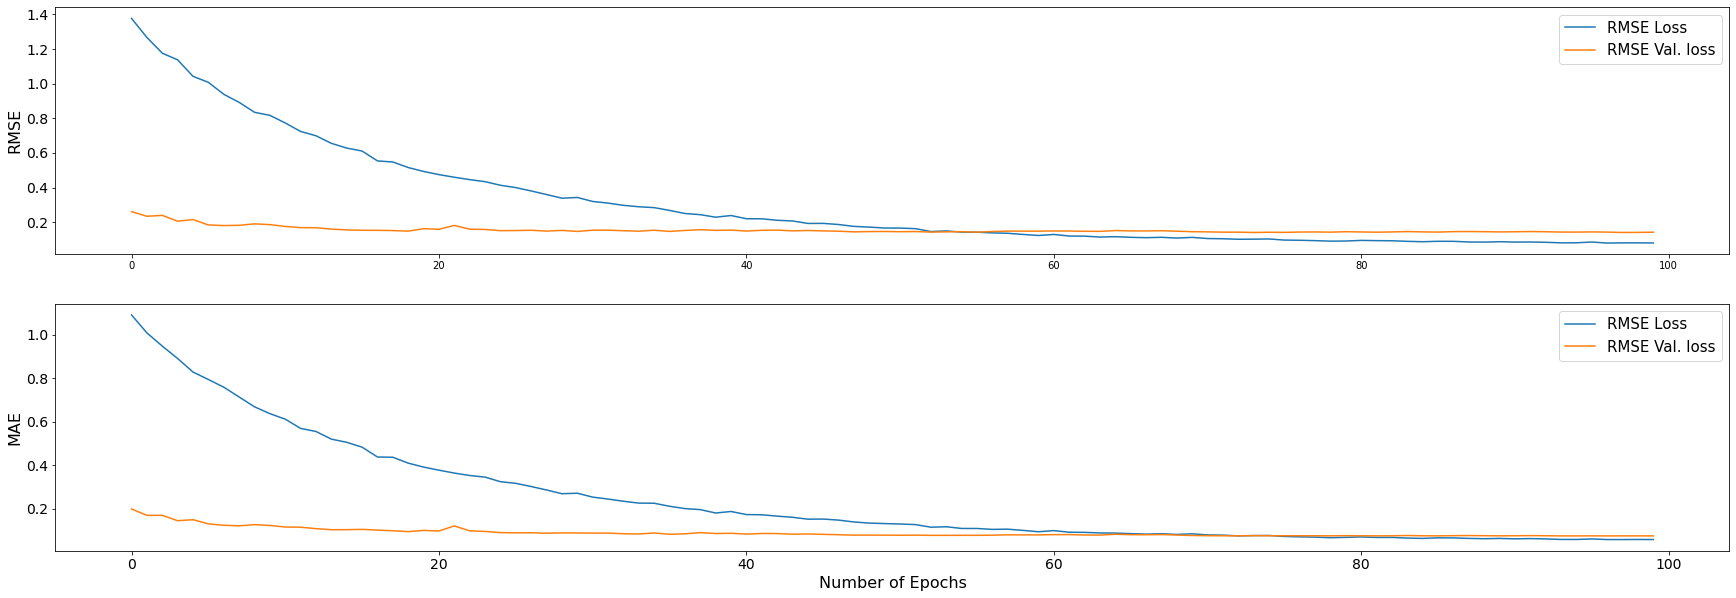

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['with_scalar']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['convlstm_deep_scalar'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['convlstm_deep_scalar'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.01406578578054905
Test MAE = 0.0775323374569416
Test RMSE = 0.11859323099255561


In [ ]:
#generate predictions
predictions = prediction_gen(test_input, models[country]['3/3']['convlstm_deep_scalar'], batch_size, True)
model_predictions[country]['3/3']['convlstm_deep_scalar'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

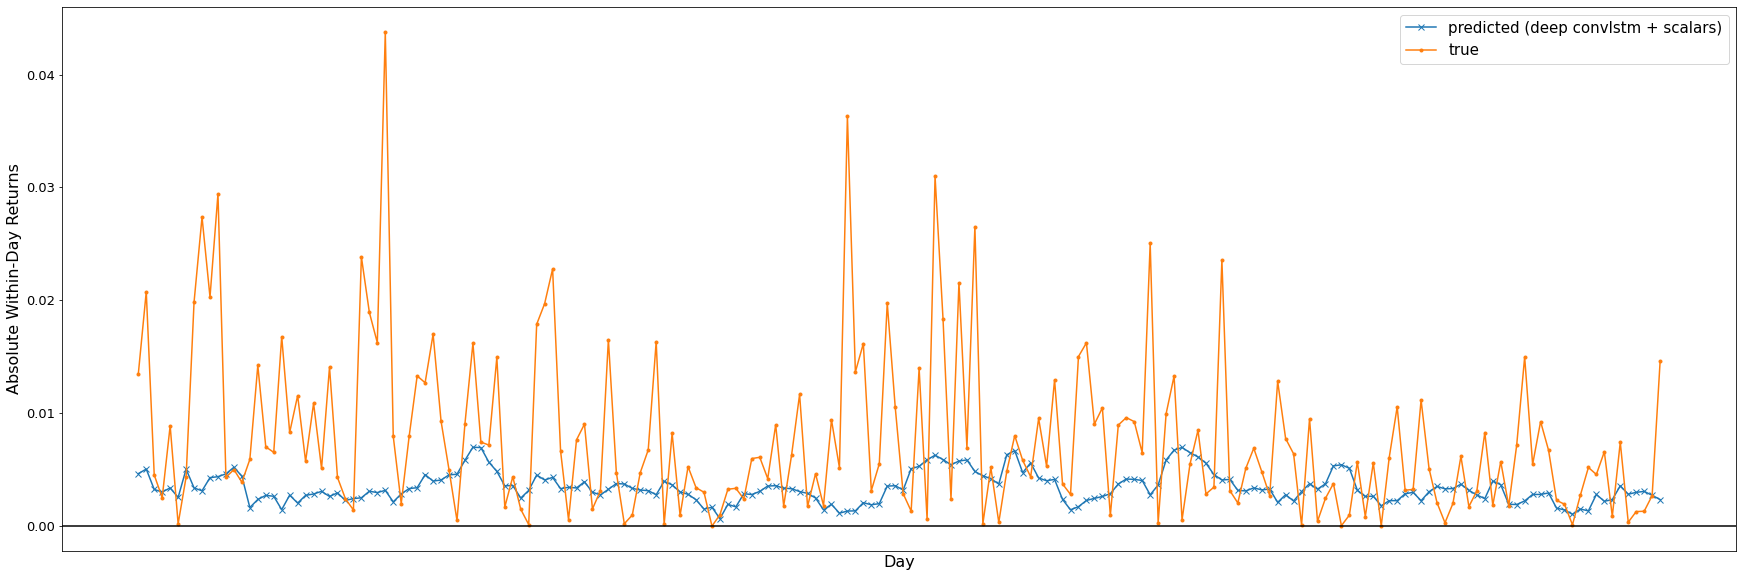

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['convlstm_deep_scalar'], label='predicted (deep convlstm + scalars)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks([], fontsize=13)
plt.xlabel("Day", fontsize=16)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black')
plt.ylabel("Absolute Within-Day Returns", fontsize=16)
plt.show()

# Model Training (UK100 Data)

We will be training for the same models as we did in the previous part, but with UK100 data instead

In [ ]:
#specify the data we will be using
country = 'uk'

ConvLSTM Model

In [ ]:
#define the convlstm model
for i in range(3):
  key = f'{i+1}/3'

  input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
  x = add_dimension(name='img_add_dim')(input)

  x = keras.layers.ConvLSTM2D(filters=16, 
                              kernel_size=3, 
                              strides=1, 
                              padding='same', 
                              recurrent_activation='sigmoid',
                              data_format='channels_last',
                              stateful=True,
                              name='convlstm2d_3')(x)

  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(filters=16, kernel_size=5, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1)(x)

  models[country][key]['convlstm'] = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_convlstm_model')

  if i + 1 == 3:
    models[country][key]['convlstm'].summary()

Model: "3/3_uk_convlstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(64, 20, 52, 52)]        0         
                                                                 
 img_add_dim (add_dimension)  (64, 20, 52, 52, 1)      0         
                                                                 
 convlstm2d_3 (ConvLSTM2D)   (64, 52, 52, 16)          9856      
                                                                 
 batch_normalization_4 (Batc  (64, 52, 52, 16)         64        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (64, 52, 52, 16)          6416      
                                                                 
 batch_normalization_5 (Batc  (64, 52, 52, 16)         64        
 hNormalization)                             

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 5e-4

train_input = X_train[country]['img_only']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['img_only']['3/3'], y_valid[country]['3/3'])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country][key]['convlstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                         loss=keras.losses.MeanSquaredError(),
                                         metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
model_fits[country]['3/3']['convlstm'] = models[country]['3/3']['convlstm'].fit(x=train_input, 
                                                                                y=train_output, 
                                                                                epochs=N_epoch, 
                                                                                batch_size=batch_size, 
                                                                                verbose=2, 
                                                                                validation_data=valid_data, 
                                                                                shuffle=False,
                                                                                callbacks=[reset_LSTM_state()])

Epoch 1/100
21/21 - 28s - loss: 3.8793 - mean_absolute_error: 1.6007 - root_mean_squared_error: 1.9696 - val_loss: 0.0230 - val_mean_absolute_error: 0.0846 - val_root_mean_squared_error: 0.1518 - 28s/epoch - 1s/step
Epoch 2/100
21/21 - 17s - loss: 2.4237 - mean_absolute_error: 1.3466 - root_mean_squared_error: 1.5568 - val_loss: 0.1281 - val_mean_absolute_error: 0.3261 - val_root_mean_squared_error: 0.3579 - 17s/epoch - 797ms/step
Epoch 3/100
21/21 - 17s - loss: 1.3224 - mean_absolute_error: 0.9620 - root_mean_squared_error: 1.1500 - val_loss: 0.0441 - val_mean_absolute_error: 0.1560 - val_root_mean_squared_error: 0.2099 - 17s/epoch - 799ms/step
Epoch 4/100
21/21 - 17s - loss: 0.7712 - mean_absolute_error: 0.7146 - root_mean_squared_error: 0.8782 - val_loss: 0.2039 - val_mean_absolute_error: 0.4275 - val_root_mean_squared_error: 0.4515 - 17s/epoch - 791ms/step
Epoch 5/100
21/21 - 17s - loss: 0.0879 - mean_absolute_error: 0.2397 - root_mean_squared_error: 0.2965 - val_loss: 0.0609 - val

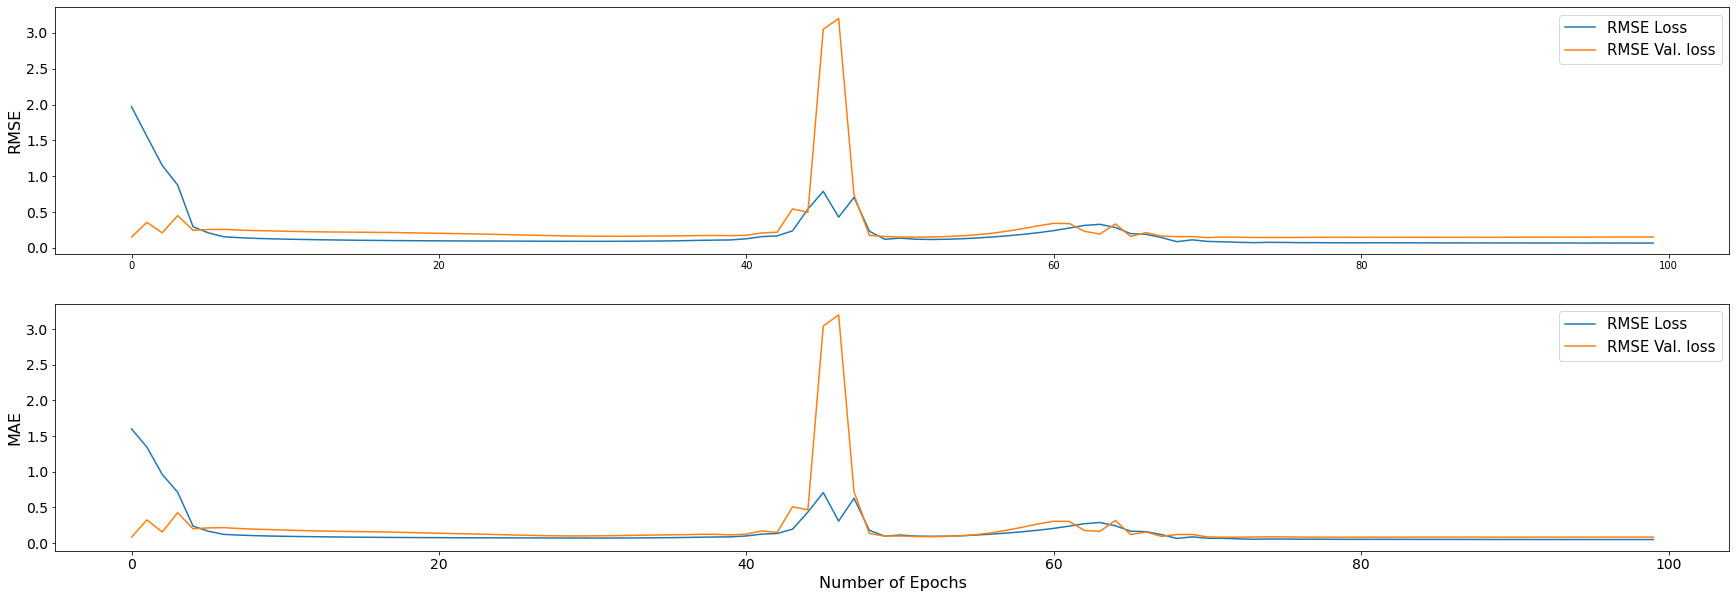

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['convlstm'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['convlstm'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['convlstm'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['convlstm'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['img_only']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['convlstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['convlstm'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.014368028733879329
Test MAE = 0.0840331919491291
Test RMSE = 0.1197660182416439


In [ ]:
#generate predictions
predictions = prediction_gen(test_input, models[country]['3/3']['convlstm'], batch_size, False)
model_predictions[country]['3/3']['convlstm'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]

rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

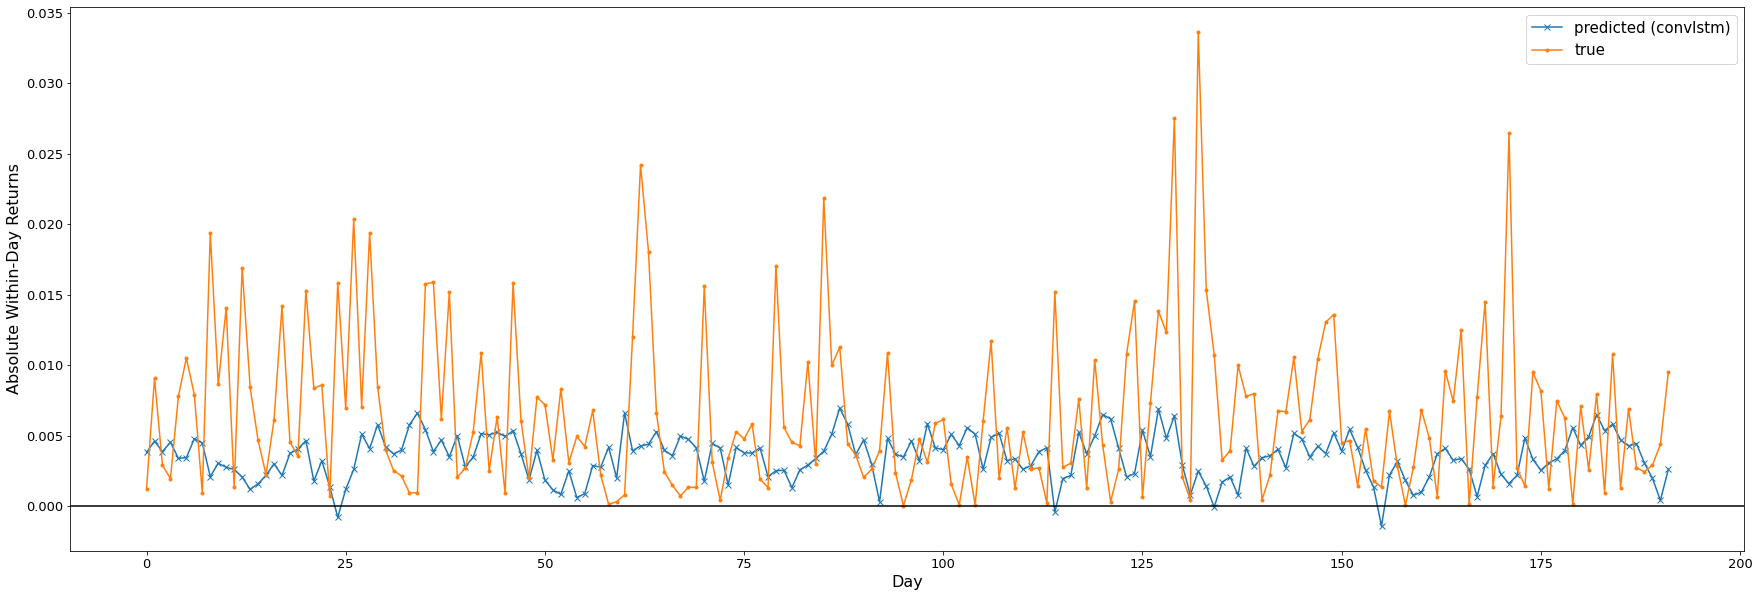

In [ ]:
##plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['convlstm'], label='predicted (convlstm)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks(fontsize=13)
plt.xlabel("Day", fontsize=16)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black')
plt.ylabel("Absolute Within-Day Returns", fontsize=16)
plt.show()

DeepConvLSTM Model

This model is the main model that we are proposing in this report. It stacks multiple blocks of ConvLSTM-CNN netowrks together and incorporates approriate maxpooling between them. To better regularise the model, we do add a dropout layter towards the end of it.

In [ ]:
#define the convlstm-cnn block
def convlstm_cnn_block(filter_num, kernel_num, return_sequence, name):

  model_list = list(range(7))
  
  #case when we want ConvLSTM to return sequence
  if return_sequence:
    model_list[0] = keras.layers.ConvLSTM2D(filters=filter_num, 
                                kernel_size=kernel_num, 
                                strides=1, 
                                padding='same', 
                                recurrent_activation='sigmoid', 
                                data_format='channels_last', 
                                return_sequences=return_sequence, 
                                stateful=True,
                                name='convlstm')
    
    model_list[1] = keras.layers.BatchNormalization(name='batchnorm1')

    model_list[2] = keras.layers.Conv3D(filters=filter_num, kernel_size=kernel_num, padding='same', activation='relu', name='conv1')
    model_list[3] = keras.layers.Conv3D(filters=filter_num, kernel_size=1, padding='same', activation='relu', name='conv2')
    model_list[4] = keras.layers.Conv3D(filters=filter_num, kernel_size=1, padding='same', name='conv3')
    model_list[5] = keras.layers.BatchNormalization(name='batchnorm2')
    model_list[6] = keras.layers.ReLU(name='relu')

  #case when we do not want ConvLSTM to return sequence
  else:
    model_list[0] = keras.layers.ConvLSTM2D(filters=filter_num, 
                                kernel_size=kernel_num, 
                                strides=1, 
                                padding='same', 
                                recurrent_activation='sigmoid', 
                                data_format='channels_last', 
                                return_sequences=return_sequence, 
                                stateful=True,
                                name='convlstm')
    
    model_list[1] = keras.layers.BatchNormalization(name='batchnorm1')

    model_list[2] = keras.layers.Conv2D(filters=filter_num, kernel_size=kernel_num, padding='same', activation='relu', name='conv1')
    model_list[3] = keras.layers.Conv2D(filters=filter_num, kernel_size=1, padding='same', activation='relu', name='conv2')
    model_list[4] = keras.layers.Conv2D(filters=filter_num, kernel_size=1, padding='same', name='conv3')
    model_list[5] = keras.layers.BatchNormalization(name='batchnorm2')
    model_list[6] = keras.layers.ReLU(name='relu')

  return tf.keras.models.Sequential(model_list, name=name)

In [ ]:
#define deep convlstm model (us data)
for i in range(3):
  key = f'{i+1}/3'

  input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
  x = add_dimension(name='img_add_dim')(input)

  x = convlstm_cnn_block(filter_num=4, kernel_num=5, return_sequence=True, name='convlstm_cnn_block1')(x)

  x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling1')(x)

  x = convlstm_cnn_block(filter_num=16, kernel_num=3, return_sequence=True, name='convlstm_cnn_block2')(x)

  x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling2')(x)

  x = convlstm_cnn_block(filter_num=64, kernel_num=3, return_sequence=False, name='convlstm_cnn_block3')(x)

  x = keras.layers.GlobalAveragePooling2D(name='globalaveragepooling')(x)
  x = keras.layers.Dropout(0.8, name='dropout')(x)
  x = keras.layers.Dense(1, name='output')(x)

  models[country][key]['deep_convlstm'] = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_convlstm_deep_model')

  if i + 1 == 3:
    models[country][key]['deep_convlstm'].summary()

Model: "3/3_uk_convlstm_deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(64, 20, 52, 52)]        0         
                                                                 
 img_add_dim (add_dimension)  (64, 20, 52, 52, 1)      0         
                                                                 
 convlstm_cnn_block1 (Sequen  (64, 20, 52, 52, 4)      4092      
 tial)                                                           
                                                                 
 maxpooling1 (MaxPooling3D)  (64, 10, 26, 26, 4)       0         
                                                                 
 convlstm_cnn_block2 (Sequen  (64, 10, 26, 26, 16)     19184     
 tial)                                                           
                                                                 
 maxpooling2 (MaxPooling3D)  (64, 5, 13,

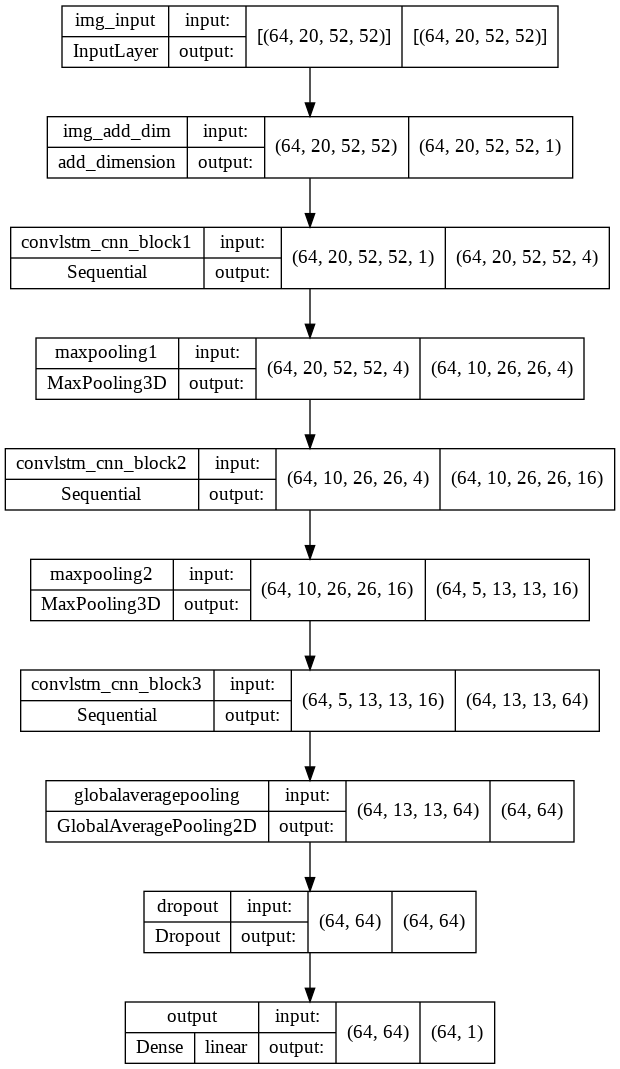

In [ ]:
#display architecture of network
tf.keras.utils.plot_model(models[country][key]['deep_convlstm'], show_shapes=True, show_layer_activations=True)

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 1e-4

train_input = X_train[country]['img_only']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['img_only']['3/3'], y_valid[country]['3/3'])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country]['3/3']['deep_convlstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                                loss=keras.losses.MeanSquaredError(),
                                                metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
model_fits[country]['3/3']['deep_convlstm'] = models[country]['3/3']['deep_convlstm'].fit(x=train_input, 
                                                                                          y=train_output, 
                                                                                          epochs=N_epoch, 
                                                                                          batch_size=batch_size, 
                                                                                          verbose=2, 
                                                                                          validation_data=valid_data, 
                                                                                          shuffle=False,
                                                                                          callbacks=[reset_LSTM_state()])


Epoch 1/100
21/21 - 30s - loss: 1.0190 - mean_absolute_error: 0.8173 - root_mean_squared_error: 1.0095 - val_loss: 0.0329 - val_mean_absolute_error: 0.1036 - val_root_mean_squared_error: 0.1815 - 30s/epoch - 1s/step
Epoch 2/100
21/21 - 22s - loss: 0.7881 - mean_absolute_error: 0.7034 - root_mean_squared_error: 0.8878 - val_loss: 0.0345 - val_mean_absolute_error: 0.1094 - val_root_mean_squared_error: 0.1857 - 22s/epoch - 1s/step
Epoch 3/100
21/21 - 22s - loss: 0.6014 - mean_absolute_error: 0.6153 - root_mean_squared_error: 0.7755 - val_loss: 0.0359 - val_mean_absolute_error: 0.1144 - val_root_mean_squared_error: 0.1894 - 22s/epoch - 1s/step
Epoch 4/100
21/21 - 22s - loss: 0.4617 - mean_absolute_error: 0.5417 - root_mean_squared_error: 0.6795 - val_loss: 0.0381 - val_mean_absolute_error: 0.1225 - val_root_mean_squared_error: 0.1951 - 22s/epoch - 1s/step
Epoch 5/100
21/21 - 22s - loss: 0.3868 - mean_absolute_error: 0.4966 - root_mean_squared_error: 0.6219 - val_loss: 0.0405 - val_mean_abs

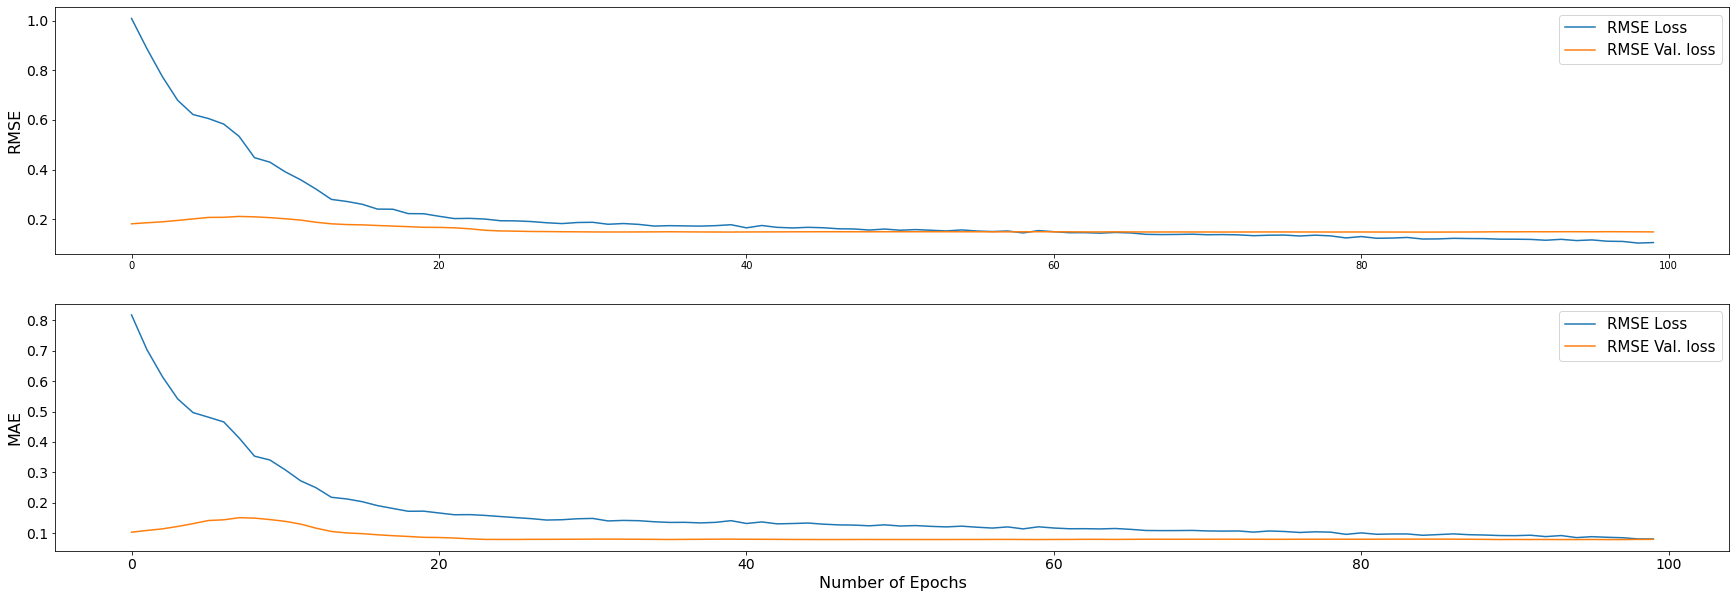

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['deep_convlstm'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['deep_convlstm'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['deep_convlstm'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['deep_convlstm'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['img_only']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['deep_convlstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['deep_convlstm'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.011836540549993516
Test MAE = 0.07555072724819184
Test RMSE = 0.10879570901393891


In [ ]:
#generate predictions
predictions = prediction_gen(test_input, models[country]['3/3']['deep_convlstm'], batch_size, False)
model_predictions[country]['3/3']['deep_convlstm'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

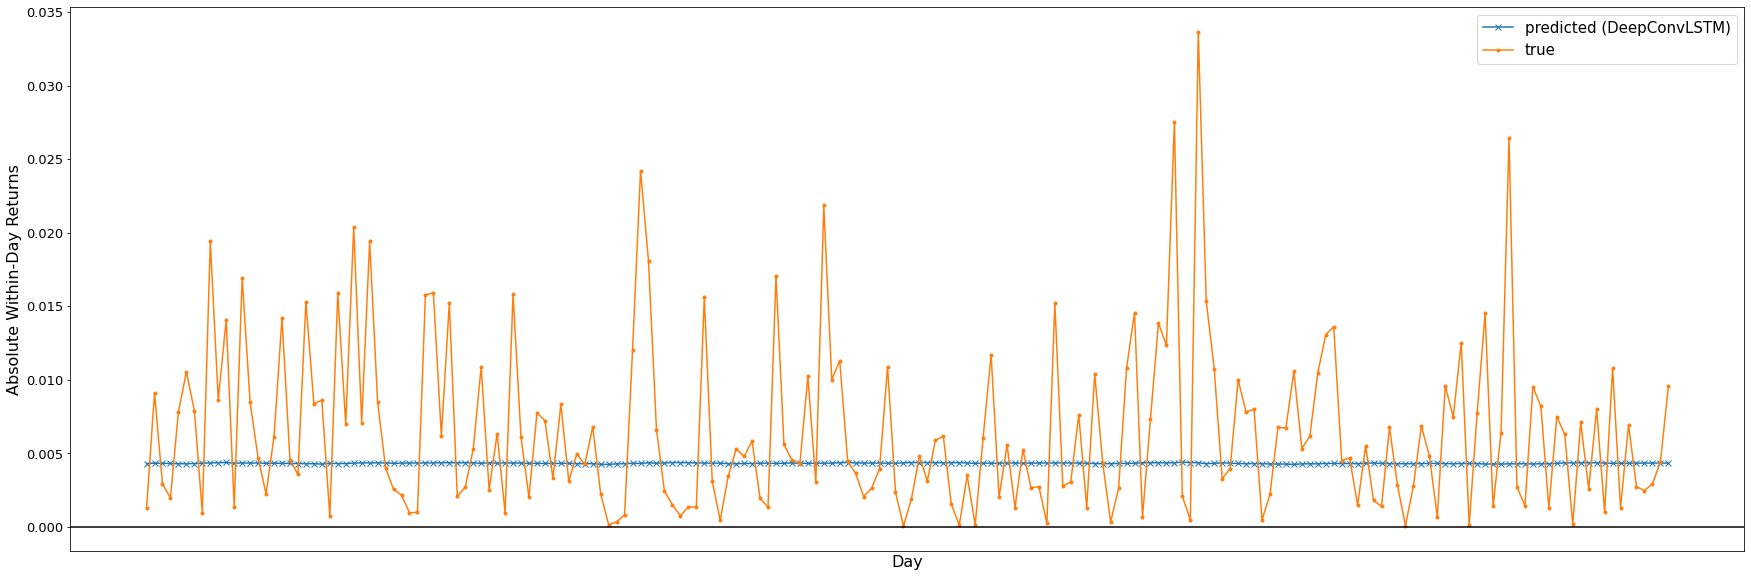

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['deep_convlstm'], label='predicted (DeepConvLSTM)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks([],fontsize=13)
plt.xlabel("Day", fontsize=16)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black')
plt.ylabel("Absolute Within-Day Returns", fontsize=16)
plt.show()

1D CNN-LSTM Model

This model is to serve as a simple benchmark for our other model.



In [ ]:
#define cnn part of model
input = keras.layers.Input(shape=(img_dim[country], ))

x = add_dimension()(input)

x = keras.layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(1, padding='same')(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Flatten()(x)

conv_1d = keras.Model(inputs=input, outputs=x)
conv_1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 add_dimension (add_dimensio  (None, 52, 1)            0         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 52, 16)            32        
                                                                 
 batch_normalization_6 (Batc  (None, 52, 16)           64        
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 52, 16)           0         
 )                                                               
                                                             

In [ ]:
#define 1d cnn lstm model
for i in range(3):
  key = f'{i+1}/3'

  input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country]))

  x = keras.layers.TimeDistributed(conv_1d)(input)

  x = keras.layers.LSTM(16, stateful=True)(x)

  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Dense(1)(x)

  models[country][key]['cnn_lstm'] = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_cnn_lstm_model')

  if i + 1 == 3:
    models[country][key]['cnn_lstm'].summary()

Model: "3/3_uk_cnn_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(64, 20, 52)]            0         
                                                                 
 time_distributed_2 (TimeDis  (64, 20, 832)            96        
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (64, 16)                  54336     
                                                                 
 batch_normalization_9 (Batc  (64, 16)                 64        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (64, 1)                   17        
                                                                 
Total params: 54,513
Trainable params: 54,449

In [ ]:
#specify training hyperparameter
N_epoch = 10
learn_rate = 5e-4

#specify data for training
train_input = X_train[country]['price_only']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['price_only']['3/3'], y_valid[country]['3/3'])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country]['3/3']['cnn_lstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                           loss=keras.losses.MeanSquaredError(),
                                           metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
start = time.time()
model_fits[country]['3/3']['cnn_lstm'] = models[country]['3/3']['cnn_lstm'].fit(x=train_input, 
                                                                                y=train_output, 
                                                                                epochs=N_epoch, 
                                                                                batch_size=batch_size, 
                                                                                verbose=2, 
                                                                                validation_data=valid_data, 
                                                                                shuffle=False,
                                                                                callbacks=[reset_LSTM_state()])

Epoch 1/10
21/21 - 4s - loss: 0.1100 - mean_absolute_error: 0.2199 - root_mean_squared_error: 0.3316 - val_loss: 0.0513 - val_mean_absolute_error: 0.1881 - val_root_mean_squared_error: 0.2265 - 4s/epoch - 199ms/step
Epoch 2/10
21/21 - 0s - loss: 0.0173 - mean_absolute_error: 0.1015 - root_mean_squared_error: 0.1315 - val_loss: 0.0231 - val_mean_absolute_error: 0.0840 - val_root_mean_squared_error: 0.1518 - 330ms/epoch - 16ms/step
Epoch 3/10
21/21 - 0s - loss: 0.0149 - mean_absolute_error: 0.0951 - root_mean_squared_error: 0.1222 - val_loss: 0.0216 - val_mean_absolute_error: 0.0793 - val_root_mean_squared_error: 0.1469 - 331ms/epoch - 16ms/step
Epoch 4/10
21/21 - 0s - loss: 0.0124 - mean_absolute_error: 0.0856 - root_mean_squared_error: 0.1115 - val_loss: 0.0219 - val_mean_absolute_error: 0.0829 - val_root_mean_squared_error: 0.1481 - 373ms/epoch - 18ms/step
Epoch 5/10
21/21 - 0s - loss: 0.0097 - mean_absolute_error: 0.0760 - root_mean_squared_error: 0.0985 - val_loss: 0.0222 - val_mean

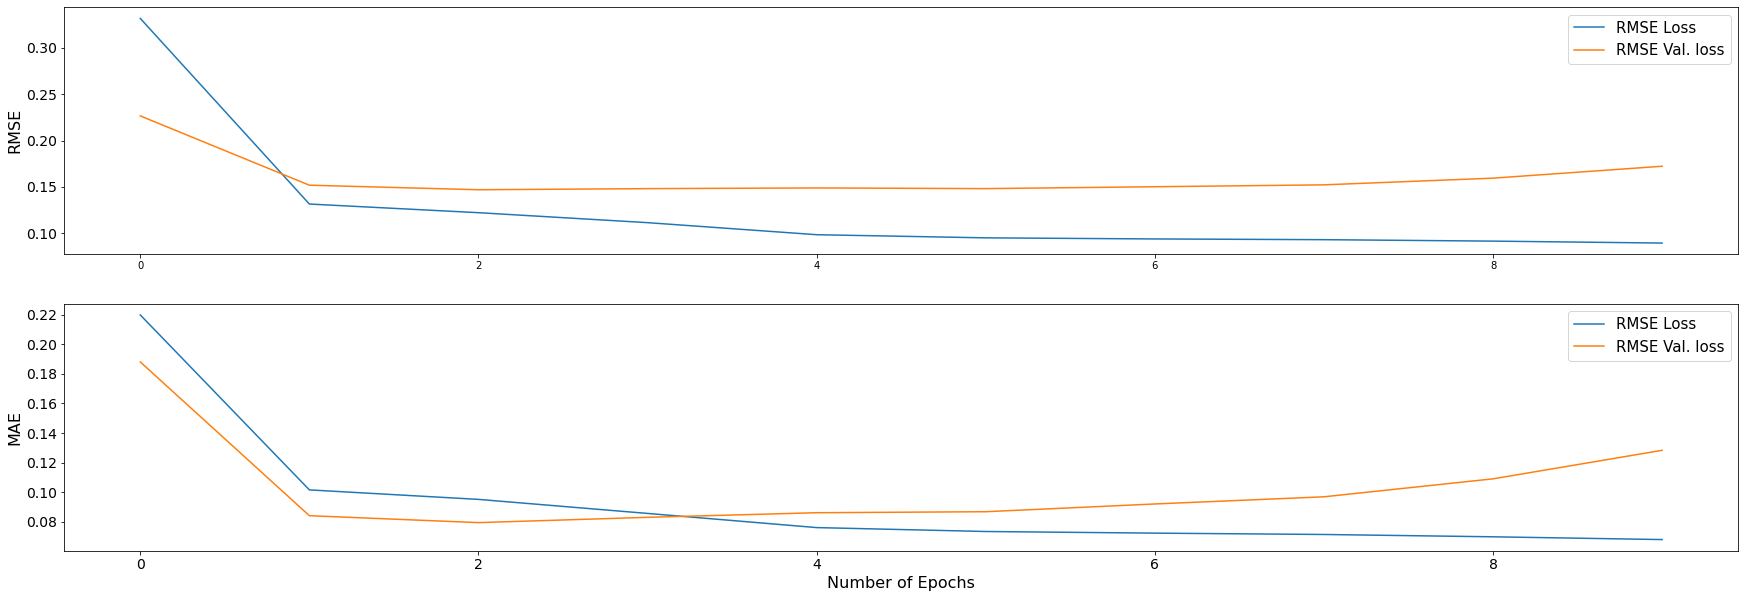

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['cnn_lstm'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['cnn_lstm'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['cnn_lstm'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['cnn_lstm'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['price_only']['3/3']
test_output = y_test[country]['3/3']

#repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['cnn_lstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['cnn_lstm'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.015396577082574367
Test MAE = 0.1084024177491665
Test RMSE = 0.12408294841647148


In [ ]:
#generate predictions
test_input = X_test[country]['price_only']['3/3']
test_output = y_test[country]['3/3']

predictions = prediction_gen(test_input, models[country]['3/3']['cnn_lstm'], batch_size, False)
model_predictions[country]['3/3']['cnn_lstm'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

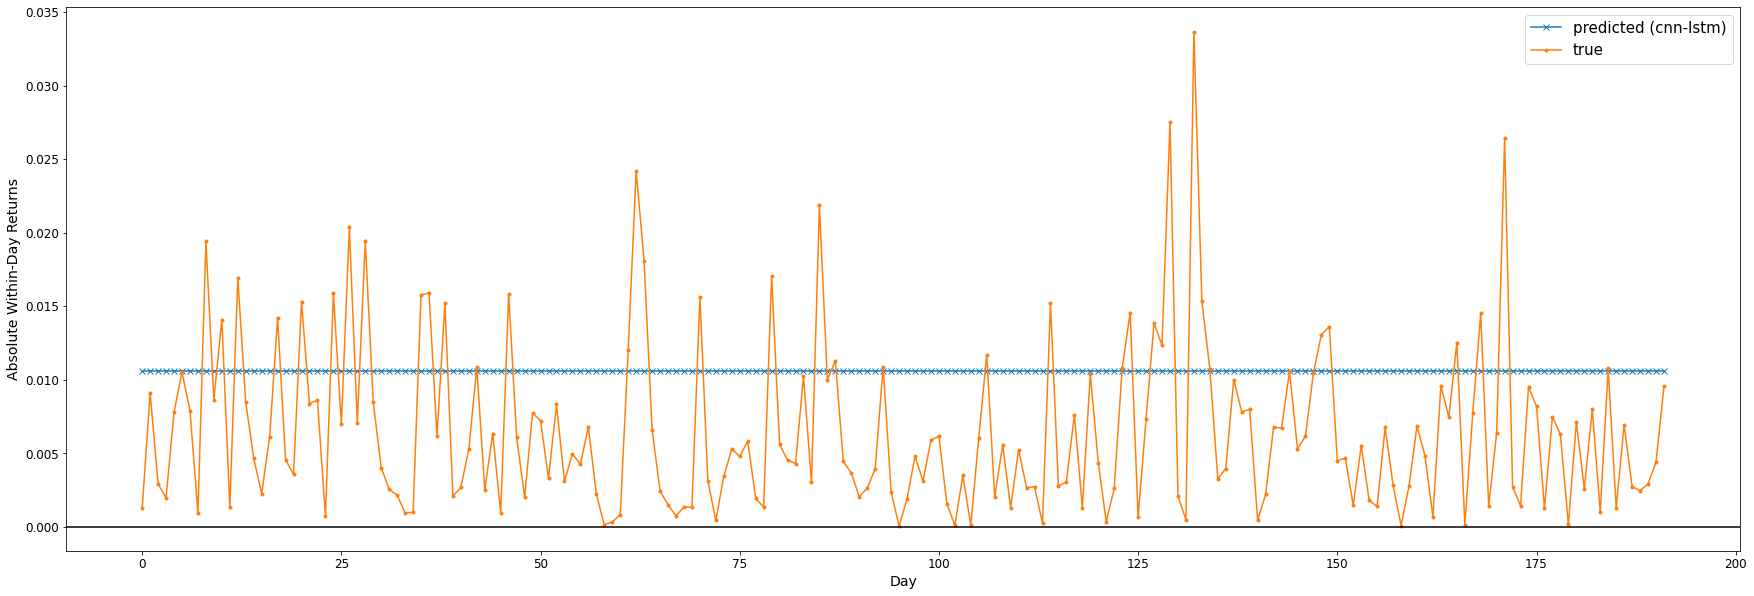

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['cnn_lstm'], label='predicted (cnn-lstm)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks(fontsize=12)
plt.xlabel("Day", fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Absolute Within-Day Returns", fontsize=14)
plt.axhline(y=0, color='black')
plt.rcParams["figure.figsize"] = (30, 10)
plt.show()

ARIMA Model

This model is a benchmark model that uses traditional statistics based techniques.

In [ ]:
#define model using ARIMA with automatically determined parameters p, d, q using past 20 days data
pred = {}
for i in range(3):
  key = f'{i+1}/3'

  arima_test = X_test[country]['return_only'][key]
  pred[key] = []
  for j in range(arima_test.shape[0]):
    temp_model = pm.auto_arima(arima_test[j], error_action='ignore')
    pred[key].append(temp_model.predict(1)) #generate prediction for next day

In [ ]:
#rescale predictions
model_predictions[country]['3/3']['arima'] = [rescaling(x, max_return[country], min_return[country]) for x in pred['3/3']]

#call and rescale true values
true_vals = y_arima[country]['3/3']
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in true_vals]

In [ ]:
#print loss for ARIMA
to_print = [MSE(pred['3/3'], true_vals), MAE(pred['3/3'], true_vals), RMSE(pred['3/3'], true_vals)]
model_test[country]['3/3']['arima'] = [MSE(pred['3/3'], true_vals), MAE(pred['3/3'], true_vals), RMSE(pred['3/3'], true_vals)]

print(f'MSE = {to_print[0]}')
print(f'MAE = {to_print[1]}')
print(f'RMSE = {to_print[2]}')

MSE = 0.01385735503525634
MAE = 0.08781134633467597
RMSE = 0.11771726736233873


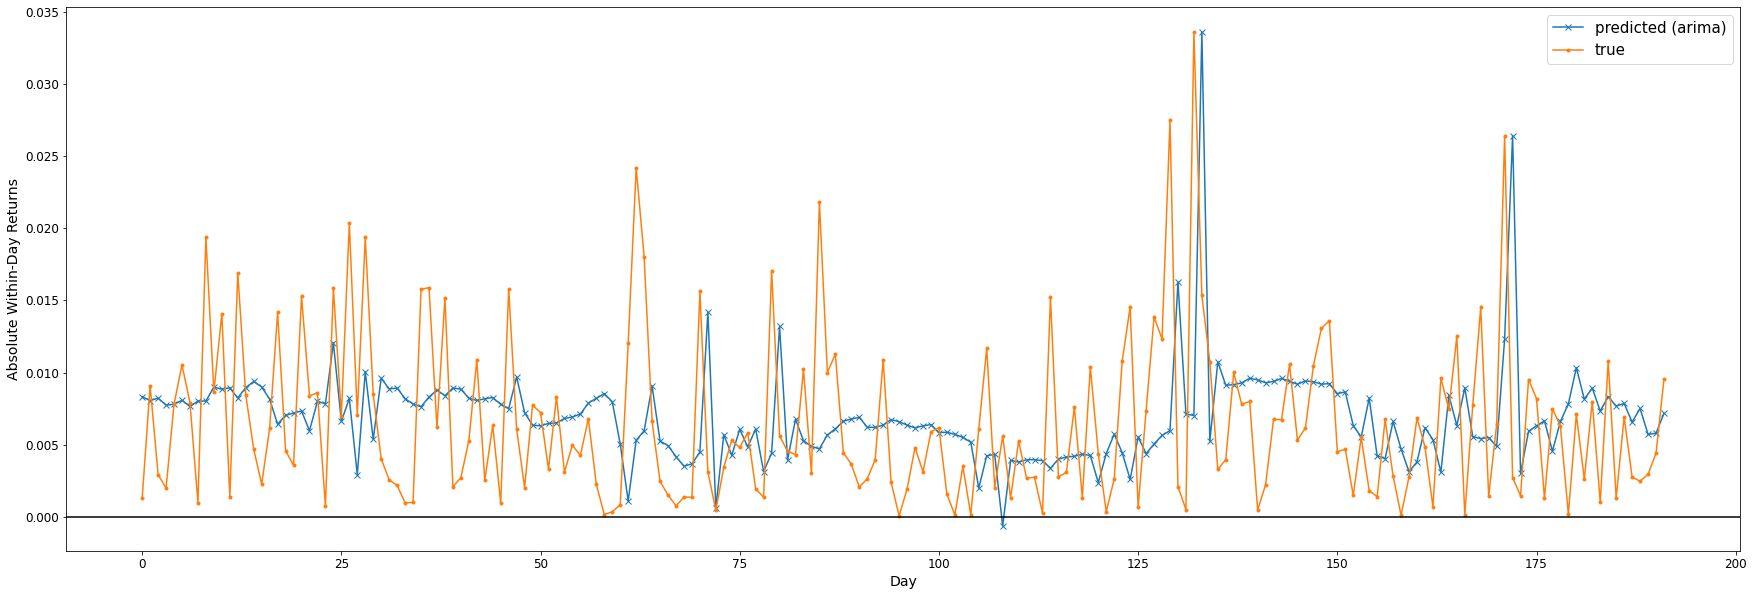

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['arima'], label='predicted (arima)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks(fontsize=12)
plt.xlabel("Day", fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Absolute Within-Day Returns", fontsize=14)
plt.axhline(y=0, color='black')
plt.rcParams["figure.figsize"] = (30, 10)
plt.show()

DeepConvLSTM + Max-Min Model

This model serves to be an extension of the DeepConvLSTM model that we proposed. Aside from the fundemental architecture of DeepConvLSTM, it further incorporates the maximum and minimum values into the network, via an image (CNN) and via just values (LSTM). 

In [ ]:
#define Conv2D netowrk for max and min images
input = keras.layers.Input(shape=(timestep, timestep))

x = add_dimension()(input)

x = keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding='same', activation='relu', name='conv11')(x)
x = keras.layers.Conv2D(filters=4, kernel_size=1, strides=1, padding='same', activation='relu', name='conv12')(x)
x = keras.layers.Conv2D(filters=4, kernel_size=1, strides=1, padding='same', name='conv13')(x)
x = keras.layers.BatchNormalization(name='batchnorm1')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same', name='maxpooling1')(x)
x = keras.layers.ReLU(name='relu1')(x)

x = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv21')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='same', activation='relu', name='conv22')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='same', name='conv23')(x)
x = keras.layers.BatchNormalization(name='batchnorm2')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same', name='maxpooling2')(x)
x = keras.layers.ReLU(name='relu2')(x)

x = keras.layers.Flatten(name='flatten')(x)

conv_2d = keras.Model(inputs=input, outputs=x, name='max_min_img_conv')
conv_2d.summary()

Model: "max_min_img_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 20)]          0         
                                                                 
 add_dimension_1 (add_dimens  (None, 20, 20, 1)        0         
 ion)                                                            
                                                                 
 conv11 (Conv2D)             (None, 20, 20, 4)         104       
                                                                 
 conv12 (Conv2D)             (None, 20, 20, 4)         20        
                                                                 
 conv13 (Conv2D)             (None, 20, 20, 4)         20        
                                                                 
 batchnorm1 (BatchNormalizat  (None, 20, 20, 4)        16        
 ion)                                             

In [ ]:
#define additional parameters
month_dim = 12
max_min_dim = 2


#define main model
for i in range(3):
  key = f'{i+1}/3'

  img_input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
  max_min_input = keras.layers.Input(batch_shape=(batch_size, timestep, max_min_dim, ), name='max_min_input')
  max_img_input = keras.layers.Input(batch_shape=(batch_size, timestep, timestep), name='max_img_input')
  min_img_input = keras.layers.Input(batch_shape=(batch_size, timestep, timestep), name='min_img_input')

  all_inputs = [img_input, max_min_input, max_img_input, min_img_input]
  
  x_img = add_dimension(name='img_add_dim')(img_input)

  x_img = convlstm_cnn_block(filter_num=4, kernel_num=5, return_sequence=True, name='convlstm_cnn_block1')(x_img)

  x_img = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling1')(x_img)

  x_img = convlstm_cnn_block(filter_num=16, kernel_num=3, return_sequence=True, name='convlstm_cnn_block2')(x_img)

  x_img = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling2')(x_img)

  x_img = convlstm_cnn_block(filter_num=64, kernel_num=3, return_sequence=False, name='convlstm_cnn_block3')(x_img)

  x_img = keras.layers.GlobalAveragePooling2D(name='globalaveragepooling')(x_img)

  x_max_min = keras.layers.LSTM(units=16, stateful=True, name='max_min_lstm')(max_min_input)
  x_max_min = keras.layers.BatchNormalization(name='max_min_batchnorm')(x_max_min)

  x_max_img = conv_2d(max_img_input)
  x_min_img = conv_2d(min_img_input)

  x = keras.layers.Concatenate(name='concatenate')([x_img, x_max_min, x_max_img, x_min_img])
  #x = keras.layers.Dense(128, activation='relu', name='fc')(x)
  x = keras.layers.Dropout(0.8, name='dropout')(x)

  x = keras.layers.Dense(1, name='output')(x)

  models[country][key]['convlstm_deep_scalar'] = keras.Model(inputs=all_inputs, outputs=x, name=key+f'_{country}_convlstm_deep_scalar_model')

  if i + 1 == 3:
    models[country][key]['convlstm_deep_scalar'].summary()

Model: "3/3_uk_convlstm_deep_scalar_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(64, 20, 52, 52)]   0           []                               
                                                                                                  
 img_add_dim (add_dimension)    (64, 20, 52, 52, 1)  0           ['img_input[0][0]']              
                                                                                                  
 convlstm_cnn_block1 (Sequentia  (64, 20, 52, 52, 4)  4092       ['img_add_dim[0][0]']            
 l)                                                                                               
                                                                                                  
 maxpooling1 (MaxPooling3D)     (64, 10, 26, 26, 4)  0           [

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 3e-4

train_input = X_train[country]['with_scalar']['3/3']
train_output = y_train[country]['3/3']

valid_data = (X_valid[country]['with_scalar']['3/3'], y_valid[country]['3/3'])


#set seed
tf.keras.utils.set_random_seed(0)

#compile model
models[country]['3/3']['convlstm_deep_scalar'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                                       loss=keras.losses.MeanSquaredError(),
                                                       metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
model_fits[country]['3/3']['convlstm_deep_scalar'] = models[country]['3/3']['convlstm_deep_scalar'].fit(x=train_input, 
                                                                                                        y=train_output, 
                                                                                                        epochs=N_epoch, 
                                                                                                        batch_size=batch_size, 
                                                                                                        verbose=2, 
                                                                                                        validation_data=valid_data, 
                                                                                                        shuffle=False,
                                                                                                        callbacks=[reset_LSTM_state()])

Epoch 1/100
21/21 - 21s - loss: 8.7184 - mean_absolute_error: 2.3074 - root_mean_squared_error: 2.9527 - val_loss: 0.0492 - val_mean_absolute_error: 0.1677 - val_root_mean_squared_error: 0.2217 - 21s/epoch - 979ms/step
Epoch 2/100
21/21 - 9s - loss: 6.9947 - mean_absolute_error: 2.0897 - root_mean_squared_error: 2.6448 - val_loss: 0.0841 - val_mean_absolute_error: 0.2513 - val_root_mean_squared_error: 0.2900 - 9s/epoch - 428ms/step
Epoch 3/100
21/21 - 9s - loss: 6.1791 - mean_absolute_error: 1.9723 - root_mean_squared_error: 2.4858 - val_loss: 0.1146 - val_mean_absolute_error: 0.3062 - val_root_mean_squared_error: 0.3385 - 9s/epoch - 432ms/step
Epoch 4/100
21/21 - 9s - loss: 5.0988 - mean_absolute_error: 1.7893 - root_mean_squared_error: 2.2581 - val_loss: 0.1325 - val_mean_absolute_error: 0.3334 - val_root_mean_squared_error: 0.3640 - 9s/epoch - 436ms/step
Epoch 5/100
21/21 - 9s - loss: 4.8424 - mean_absolute_error: 1.7437 - root_mean_squared_error: 2.2005 - val_loss: 0.1603 - val_mea

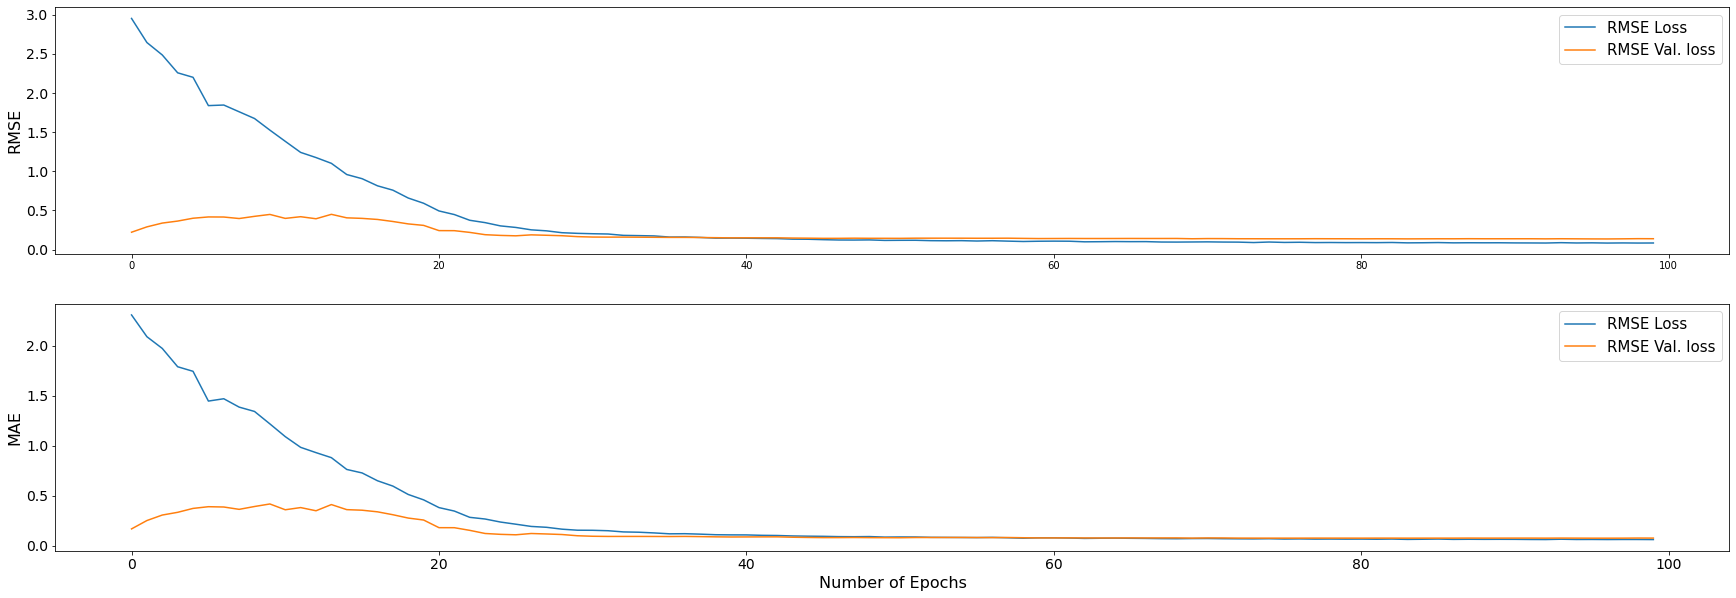

In [ ]:

#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(model_fits[country]['3/3']['convlstm_deep_scalar'].history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['with_scalar']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = models[country]['3/3']['convlstm_deep_scalar'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
model_test[country]['3/3']['convlstm_deep_scalar'] = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.010565111879259348
Test MAE = 0.07761199280619621
Test RMSE = 0.10261908978223801


In [ ]:
#generate predictions
predictions = prediction_gen(test_input, models[country]['3/3']['convlstm_deep_scalar'], batch_size, True)
model_predictions[country]['3/3']['convlstm_deep_scalar'] = [rescaling(x, max_return[country], min_return[country]) for x in predictions]
rescaled_true_vals = [rescaling(x, max_return[country], min_return[country]) for x in test_output]

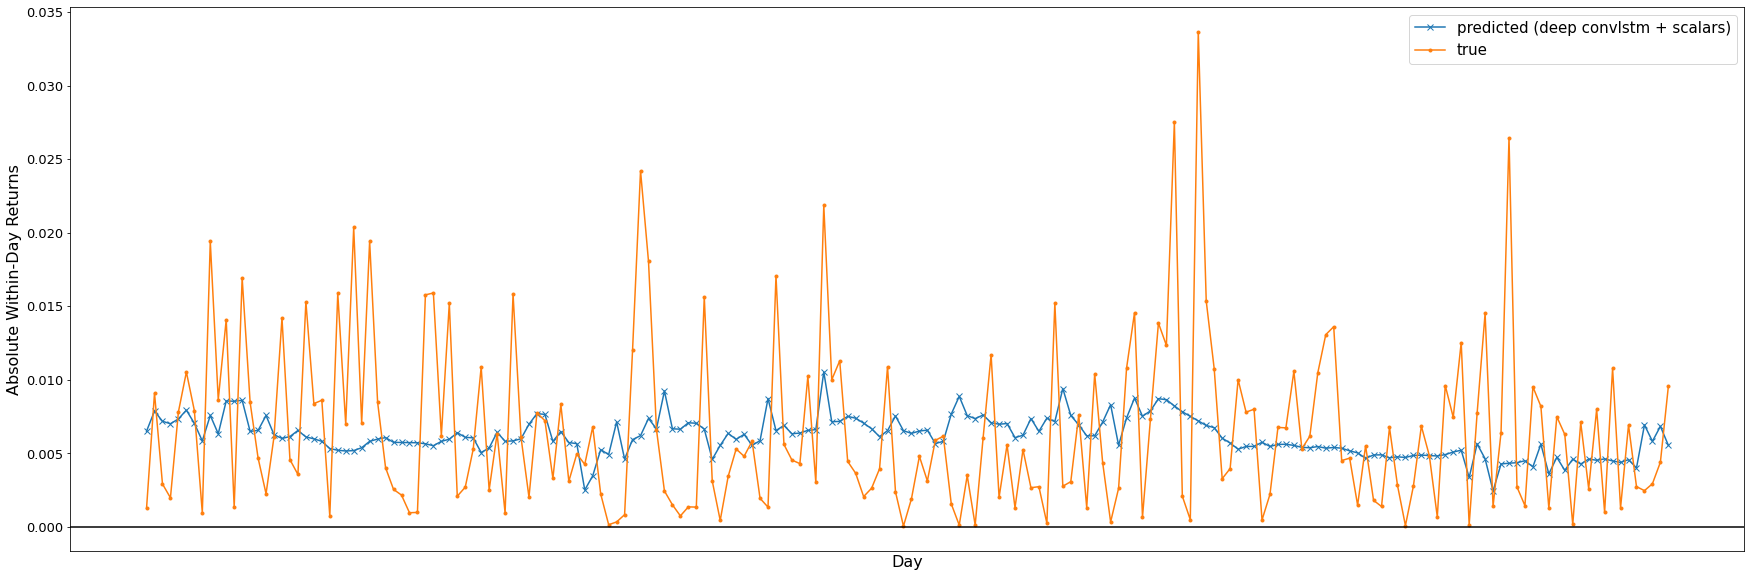

In [ ]:
#plot predicted vs true values
plt.plot(model_predictions[country]['3/3']['convlstm_deep_scalar'], label='predicted (deep convlstm + scalars)', marker='x')
plt.plot(rescaled_true_vals, label='true', marker ='.')
plt.legend(loc="upper right", prop={'size': 15})
plt.xticks([], fontsize=13)
plt.xlabel("Day", fontsize=16)
plt.yticks(fontsize=13)
plt.axhline(y=0, color='black')
plt.ylabel("Absolute Within-Day Returns", fontsize=16)
plt.show()

# Cross Validation (US500 Data Only)

Here we want to do cross validation on each of the models, using a different set of data for each try. We want to find the loss of each of the models at each sets of data. In the end, we would aggregate the losses to get a more robust measure of a model's performance.

In [ ]:
#cross validation on us data only
country = 'us'

ConvLSTM Model

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 5e-4
patience = 15

#train model on the cross validation data
for i in range(2):
  key = f'{i+1}/3'

  #specify data for training
  train_input = X_train[country]['img_only'][key]
  train_output = y_train[country][key]

  valid_data = (X_valid[country]['img_only'][key], y_valid[country][key])

  #set seed
  tf.keras.utils.set_random_seed(0)

  #compile model
  models[country][key]['convlstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                           loss=keras.losses.MeanSquaredError(),
                                           metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

  #fit model
  model_fits[country][key]['convlstm'] = models[country][key]['convlstm'].fit(x=train_input, 
                                                                              y=train_output, 
                                                                              epochs=N_epoch, 
                                                                              batch_size=batch_size, 
                                                                              verbose=2, 
                                                                              validation_data=valid_data, 
                                                                              shuffle=False,
                                                                              callbacks=[reset_LSTM_state(), earlystopping(patience)])
  
  #evaluate the model on test data
  test_input = X_test[country]['img_only'][key]
  test_output = y_test[country][key]

  #Repeat evaluation to yield average test loss and performacne
  trial_N = 50
  tf.keras.utils.set_random_seed(0)
  avg_test = []

  for _ in range(trial_N):
    trial = models[country][key]['convlstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
    avg_test.append(trial)

  avg_test = np.array(avg_test)
  model_test[country][key]['convlstm'] = avg_test.mean(axis=0)

  #print results for each part of data
  print(f'Test MSE for {key} = {avg_test.mean(axis=0)[0]}')
  print(f'Test MAE for {key} = {avg_test.mean(axis=0)[1]}')
  print(f'Test RMSE for {key} = {avg_test.mean(axis=0)[2]}')

#print result for cross validated performance
cv_tests = np.array([model_test[country][x]['convlstm'] for x in model_test[country]])
avg_cv_test = cv_tests.mean(axis=0)

print(f'Cross Validated Test MSE = {avg_cv_test[0]}')
print(f'Cross Validated Test MAE = {avg_cv_test[1]}')
print(f'Cross Validated Test RMSE = {avg_cv_test[2]}')

Epoch 1/100
7/7 - 9s - loss: 0.5678 - mean_absolute_error: 0.5939 - root_mean_squared_error: 0.7535 - val_loss: 1.0726 - val_mean_absolute_error: 1.0267 - val_root_mean_squared_error: 1.0357 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 5s - loss: 0.1974 - mean_absolute_error: 0.3989 - root_mean_squared_error: 0.4443 - val_loss: 0.2297 - val_mean_absolute_error: 0.4651 - val_root_mean_squared_error: 0.4793 - 5s/epoch - 665ms/step
Epoch 3/100
7/7 - 5s - loss: 0.3617 - mean_absolute_error: 0.5331 - root_mean_squared_error: 0.6014 - val_loss: 1.2492 - val_mean_absolute_error: 1.1109 - val_root_mean_squared_error: 1.1177 - 5s/epoch - 667ms/step
Epoch 4/100
7/7 - 5s - loss: 0.2280 - mean_absolute_error: 0.4235 - root_mean_squared_error: 0.4775 - val_loss: 0.7531 - val_mean_absolute_error: 0.8608 - val_root_mean_squared_error: 0.8678 - 5s/epoch - 675ms/step
Epoch 5/100
7/7 - 5s - loss: 0.0835 - mean_absolute_error: 0.2462 - root_mean_squared_error: 0.2890 - val_loss: 0.0341 - val_mean_absolute_erro

In [ ]:
#print result for cross validated performance
cv_tests = np.array([model_test[country][x]['convlstm'] for x in model_test[country]])
avg_cv_test = cv_tests.mean(axis=0)

print(f'Cross Validated Test MSE = {avg_cv_test[0]}')
print(f'Cross Validated Test MAE = {avg_cv_test[1]}')
print(f'Cross Validated Test RMSE = {avg_cv_test[2]}')

Cross Validated Test MSE = 0.025753198973834514
Cross Validated Test MAE = 0.12040711790323257
Cross Validated Test RMSE = 0.15593347420295078


Deep ConvLSTM Model



In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 1e-4
patience = 20

#train model on the cross validation data
for i in range(2):
  key = f'{i+1}/3'

  #specify data for training
  train_input = X_train[country]['img_only'][key]
  train_output = y_train[country][key]

  valid_data = (X_valid[country]['img_only'][key], y_valid[country][key])

  #set seed
  tf.keras.utils.set_random_seed(0)

  #compile model
  models[country][key]['deep_convlstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                           loss=keras.losses.MeanSquaredError(),
                                           metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

  #fit model
  model_fits[country][key]['deep_convlstm'] = models[country][key]['deep_convlstm'].fit(x=train_input, 
                                                                                        y=train_output, 
                                                                                        epochs=N_epoch, 
                                                                                        batch_size=batch_size, 
                                                                                        verbose=2, 
                                                                                        validation_data=valid_data, 
                                                                                        shuffle=False,
                                                                                        callbacks=[reset_LSTM_state(), earlystopping(patience)])
  
  #evaluate the model on test data
  test_input = X_test[country]['img_only'][key]
  test_output = y_test[country][key]

  #Repeat evaluation to yield average test loss and performacne
  trial_N = 50
  tf.keras.utils.set_random_seed(0)
  avg_test = []

  for _ in range(trial_N):
    trial = models[country][key]['deep_convlstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
    avg_test.append(trial)

  avg_test = np.array(avg_test)
  model_test[country][key]['deep_convlstm'] = avg_test.mean(axis=0)

  #print results for each part of data
  print(f'Test MSE for {key} = {avg_test.mean(axis=0)[0]}')
  print(f'Test MAE for {key} = {avg_test.mean(axis=0)[1]}')
  print(f'Test RMSE for {key} = {avg_test.mean(axis=0)[2]}')

#print result for cross validated performance
cv_tests = np.array([model_test[country][x]['deep_convlstm'] for x in model_test[country]])
avg_cv_test = cv_tests.mean(axis=0)

print(f'Cross Validated Test MSE = {avg_cv_test[0]}')
print(f'Cross Validated Test MAE = {avg_cv_test[1]}')
print(f'Cross Validated Test RMSE = {avg_cv_test[2]}')

Epoch 1/100
7/7 - 12s - loss: 1.5910 - mean_absolute_error: 1.0083 - root_mean_squared_error: 1.2613 - val_loss: 0.0284 - val_mean_absolute_error: 0.1368 - val_root_mean_squared_error: 0.1685 - 12s/epoch - 2s/step
Epoch 2/100
7/7 - 4s - loss: 1.4813 - mean_absolute_error: 0.9663 - root_mean_squared_error: 1.2171 - val_loss: 0.0272 - val_mean_absolute_error: 0.1345 - val_root_mean_squared_error: 0.1650 - 4s/epoch - 513ms/step
Epoch 3/100
7/7 - 3s - loss: 1.4461 - mean_absolute_error: 0.9674 - root_mean_squared_error: 1.2025 - val_loss: 0.0294 - val_mean_absolute_error: 0.1433 - val_root_mean_squared_error: 0.1714 - 3s/epoch - 478ms/step
Epoch 4/100
7/7 - 4s - loss: 1.0750 - mean_absolute_error: 0.8239 - root_mean_squared_error: 1.0368 - val_loss: 0.0331 - val_mean_absolute_error: 0.1563 - val_root_mean_squared_error: 0.1820 - 4s/epoch - 506ms/step
Epoch 5/100
7/7 - 4s - loss: 1.0644 - mean_absolute_error: 0.8184 - root_mean_squared_error: 1.0317 - val_loss: 0.0380 - val_mean_absolute_er

1D CNN-LSTM Model

In [ ]:
#specify training hyperparameter
N_epoch = 10
learn_rate = 5e-4
patience = 5


#train model on the cross validation data
for i in range(2):
  key = f'{i+1}/3'

  #specify data for training
  train_input = X_train[country]['price_only'][key]
  train_output = y_train[country][key]

  valid_data = (X_valid[country]['price_only'][key], y_valid[country][key])

  #set seed
  tf.keras.utils.set_random_seed(0)

  #compile model
  models[country][key]['cnn_lstm'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                           loss=keras.losses.MeanSquaredError(),
                                           metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

  #fit model
  model_fits[country][key]['cnn_lstm'] = models[country][key]['cnn_lstm'].fit(x=train_input, 
                                                                              y=train_output, 
                                                                              epochs=N_epoch, 
                                                                              batch_size=batch_size, 
                                                                              verbose=2, 
                                                                              validation_data=valid_data, 
                                                                              shuffle=False,
                                                                              callbacks=[reset_LSTM_state(), earlystopping(patience)])
  
  #evaluate the model on test data
  test_input = X_test[country]['price_only'][key]
  test_output = y_test[country][key]

  #Repeat evaluation to yield average test loss and performacne
  trial_N = 50
  tf.keras.utils.set_random_seed(0)
  avg_test = []

  for _ in range(trial_N):
    trial = models[country][key]['cnn_lstm'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
    avg_test.append(trial)

  avg_test = np.array(avg_test)
  model_test[country][key]['cnn_lstm'] = avg_test.mean(axis=0)

  #print results for each part of data
  print(f'Test MSE for {key} = {avg_test.mean(axis=0)[0]}')
  print(f'Test MAE for {key} = {avg_test.mean(axis=0)[1]}')
  print(f'Test RMSE for {key} = {avg_test.mean(axis=0)[2]}')

#print result for cross validated performance
cv_tests = np.array([model_test[country][x]['cnn_lstm'] for x in model_test[country]])
avg_cv_test = cv_tests.mean(axis=0)

print(f'Cross Validated Test MSE = {avg_cv_test[0]}')
print(f'Cross Validated Test MAE = {avg_cv_test[1]}')
print(f'Cross Validated Test RMSE = {avg_cv_test[2]}')

Epoch 1/10
7/7 - 5s - loss: 0.0221 - mean_absolute_error: 0.1157 - root_mean_squared_error: 0.1488 - val_loss: 0.0053 - val_mean_absolute_error: 0.0517 - val_root_mean_squared_error: 0.0727 - 5s/epoch - 669ms/step
Epoch 2/10
7/7 - 0s - loss: 0.0141 - mean_absolute_error: 0.0890 - root_mean_squared_error: 0.1186 - val_loss: 0.0043 - val_mean_absolute_error: 0.0466 - val_root_mean_squared_error: 0.0659 - 206ms/epoch - 29ms/step
Epoch 3/10
7/7 - 0s - loss: 0.0122 - mean_absolute_error: 0.0863 - root_mean_squared_error: 0.1105 - val_loss: 0.0047 - val_mean_absolute_error: 0.0483 - val_root_mean_squared_error: 0.0688 - 200ms/epoch - 29ms/step
Epoch 4/10
7/7 - 0s - loss: 0.0084 - mean_absolute_error: 0.0677 - root_mean_squared_error: 0.0914 - val_loss: 0.0042 - val_mean_absolute_error: 0.0452 - val_root_mean_squared_error: 0.0646 - 164ms/epoch - 23ms/step
Epoch 5/10
7/7 - 0s - loss: 0.0079 - mean_absolute_error: 0.0667 - root_mean_squared_error: 0.0888 - val_loss: 0.0045 - val_mean_absolute_

ARIMA Model

In [ ]:
#generate predictions for cross validation data
for i in range(2):
  key = f'{i+1}/3'

  #print results for each part of data
  model_test[country][key]['arima'] = [MSE(pred[key], true_vals), MAE(pred[key], true_vals), RMSE(pred[key], true_vals)]

  print(f'MSE for {key} = {MSE(pred[key], true_vals)}')
  print(f'RMSE for {key} = {RMSE(pred[key], true_vals)}')
  print(f'MAE for {key} = {MAE(pred[key], true_vals)}')

#print result for cross validated performance
cv_tests = np.array([model_test[country][x]['arima'] for x in model_test[country]])
avg_cv_test = cv_tests.mean(axis=0)

print(f'Cross Validated Test MSE = {avg_cv_test[0]}')
print(f'Cross Validated Test MAE = {avg_cv_test[1]}')
print(f'Cross Validated Test RMSE = {avg_cv_test[2]}')

MSE for 1/3 = 0.014910392428260675
RMSE for 1/3 = 0.12210811778199136
MAE for 1/3 = 0.08033623473516252
MSE for 2/3 = 0.014362565172787667
RMSE for 2/3 = 0.11984392004931943
MAE for 2/3 = 0.08473489957433564
Cross Validated Test MSE = 0.014011386751081635
Cross Validated Test MAE = 0.0837631888500253
Cross Validated Test RMSE = 0.118305843674562


Deep ConvLSTM Model + Max-Min Values

In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 3e-4
patience = 20

#train model on the cross validation data
for i in range(2):
  key = f'{i+1}/3'

  #specify data for training
  train_input = X_train[country]['with_scalar'][key]
  train_output = y_train[country][key]

  valid_data = (X_valid[country]['with_scalar'][key], y_valid[country][key])

  #set seed
  tf.keras.utils.set_random_seed(0)

  #compile model
  models[country][key]['convlstm_deep_scalar'].compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                           loss=keras.losses.MeanSquaredError(),
                                           metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

  #fit model
  model_fits[country][key]['convlstm_deep_scalar'] = models[country][key]['convlstm_deep_scalar'].fit(x=train_input, 
                                                                                                      y=train_output, 
                                                                                                      epochs=N_epoch, 
                                                                                                      batch_size=batch_size, 
                                                                                                      verbose=2, 
                                                                                                      validation_data=valid_data, 
                                                                                                      shuffle=False,
                                                                                                      callbacks=[reset_LSTM_state(), earlystopping(patience)])
  
  #evaluate the model on test data
  test_input = X_test[country]['with_scalar'][key]
  test_output = y_test[country][key]

  #Repeat evaluation to yield average test loss and performacne
  trial_N = 50
  tf.keras.utils.set_random_seed(0)
  avg_test = []

  for _ in range(trial_N):
    trial = models[country][key]['convlstm_deep_scalar'].evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
    avg_test.append(trial)

  avg_test = np.array(avg_test)
  model_test[country][key]['convlstm_deep_scalar'] = avg_test.mean(axis=0)

  #print results for each part of data
  print(f'Test MSE for {key} = {avg_test.mean(axis=0)[0]}')
  print(f'Test MAE for {key} = {avg_test.mean(axis=0)[1]}')
  print(f'Test RMSE for {key} = {avg_test.mean(axis=0)[2]}')

#print result for cross validated performance
cv_tests = np.array([model_test[country][x]['convlstm_deep_scalar'] for x in model_test[country]])
avg_cv_test = cv_tests.mean(axis=0)

print(f'Cross Validated Test MSE = {avg_cv_test[0]}')
print(f'Cross Validated Test MAE = {avg_cv_test[1]}')
print(f'Cross Validated Test RMSE = {avg_cv_test[2]}')

Epoch 1/100
7/7 - 9s - loss: 0.1863 - mean_absolute_error: 0.3480 - root_mean_squared_error: 0.4316 - val_loss: 0.0116 - val_mean_absolute_error: 0.0792 - val_root_mean_squared_error: 0.1075 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 2s - loss: 0.1610 - mean_absolute_error: 0.3212 - root_mean_squared_error: 0.4013 - val_loss: 0.0136 - val_mean_absolute_error: 0.0894 - val_root_mean_squared_error: 0.1167 - 2s/epoch - 293ms/step
Epoch 3/100
7/7 - 2s - loss: 0.1473 - mean_absolute_error: 0.3073 - root_mean_squared_error: 0.3838 - val_loss: 0.0112 - val_mean_absolute_error: 0.0776 - val_root_mean_squared_error: 0.1057 - 2s/epoch - 296ms/step
Epoch 4/100
7/7 - 2s - loss: 0.1338 - mean_absolute_error: 0.2885 - root_mean_squared_error: 0.3658 - val_loss: 0.0108 - val_mean_absolute_error: 0.0759 - val_root_mean_squared_error: 0.1038 - 2s/epoch - 296ms/step
Epoch 5/100
7/7 - 2s - loss: 0.1348 - mean_absolute_error: 0.2991 - root_mean_squared_error: 0.3672 - val_loss: 0.0111 - val_mean_absolute_erro

# Hyperparameter Tuning

In [ ]:
#specify what data to use
country = 'uk'
key = '3/3'

Train model with 4 ConvLSTM-CNN blocks

In [ ]:
#define model that has 4 convlstm-cnn blocks
input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
x = add_dimension(name='img_add_dim')(input)

x = convlstm_cnn_block(filter_num=4, kernel_num=5, return_sequence=True, name='convlstm_cnn_block1')(x)

x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling1')(x)

x = convlstm_cnn_block(filter_num=8, kernel_num=3, return_sequence=True, name='convlstm_cnn_block2')(x)

x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling2')(x)

x = convlstm_cnn_block(filter_num=16, kernel_num=3, return_sequence=True, name='convlstm_cnn_block3')(x)

x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling3')(x)

x = convlstm_cnn_block(filter_num=64, kernel_num=3, return_sequence=False, name='convlstm_cnn_block4')(x)

x = keras.layers.GlobalAveragePooling2D(name='globalaveragepooling')(x)
x = keras.layers.Dropout(0.8, name='dropout')(x)
x = keras.layers.Dense(1, name='output')(x)

deep_convlstm_4_blocks = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_convlstm_deep_model_4_blocks')


In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 1e-4
patience = 20

train_input = X_train[country]['img_only'][key]
train_output = y_train[country][key]

valid_data = (X_valid[country]['img_only'][key], y_valid[country][key])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
deep_convlstm_4_blocks.compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                                loss=keras.losses.MeanSquaredError(),
                                                metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
deep_convlstm_4_blocks_fits = deep_convlstm_4_blocks.fit(x=train_input, 
                                                         y=train_output, 
                                                         epochs=N_epoch, 
                                                         batch_size=batch_size, 
                                                         verbose=2, 
                                                         validation_data=valid_data, 
                                                         shuffle=False,
                                                         callbacks=[reset_LSTM_state(), earlystopping(patience)])


Epoch 1/100
21/21 - 21s - loss: 1.2717 - mean_absolute_error: 0.9054 - root_mean_squared_error: 1.1277 - val_loss: 0.0334 - val_mean_absolute_error: 0.1043 - val_root_mean_squared_error: 0.1828 - 21s/epoch - 1s/step
Epoch 2/100
21/21 - 9s - loss: 1.0942 - mean_absolute_error: 0.8386 - root_mean_squared_error: 1.0460 - val_loss: 0.0436 - val_mean_absolute_error: 0.1429 - val_root_mean_squared_error: 0.2089 - 9s/epoch - 411ms/step
Epoch 3/100
21/21 - 9s - loss: 0.9463 - mean_absolute_error: 0.7785 - root_mean_squared_error: 0.9728 - val_loss: 0.0523 - val_mean_absolute_error: 0.1740 - val_root_mean_squared_error: 0.2288 - 9s/epoch - 429ms/step
Epoch 4/100
21/21 - 8s - loss: 0.7783 - mean_absolute_error: 0.7041 - root_mean_squared_error: 0.8822 - val_loss: 0.0557 - val_mean_absolute_error: 0.1835 - val_root_mean_squared_error: 0.2360 - 8s/epoch - 386ms/step
Epoch 5/100
21/21 - 8s - loss: 0.6834 - mean_absolute_error: 0.6560 - root_mean_squared_error: 0.8267 - val_loss: 0.0549 - val_mean_a

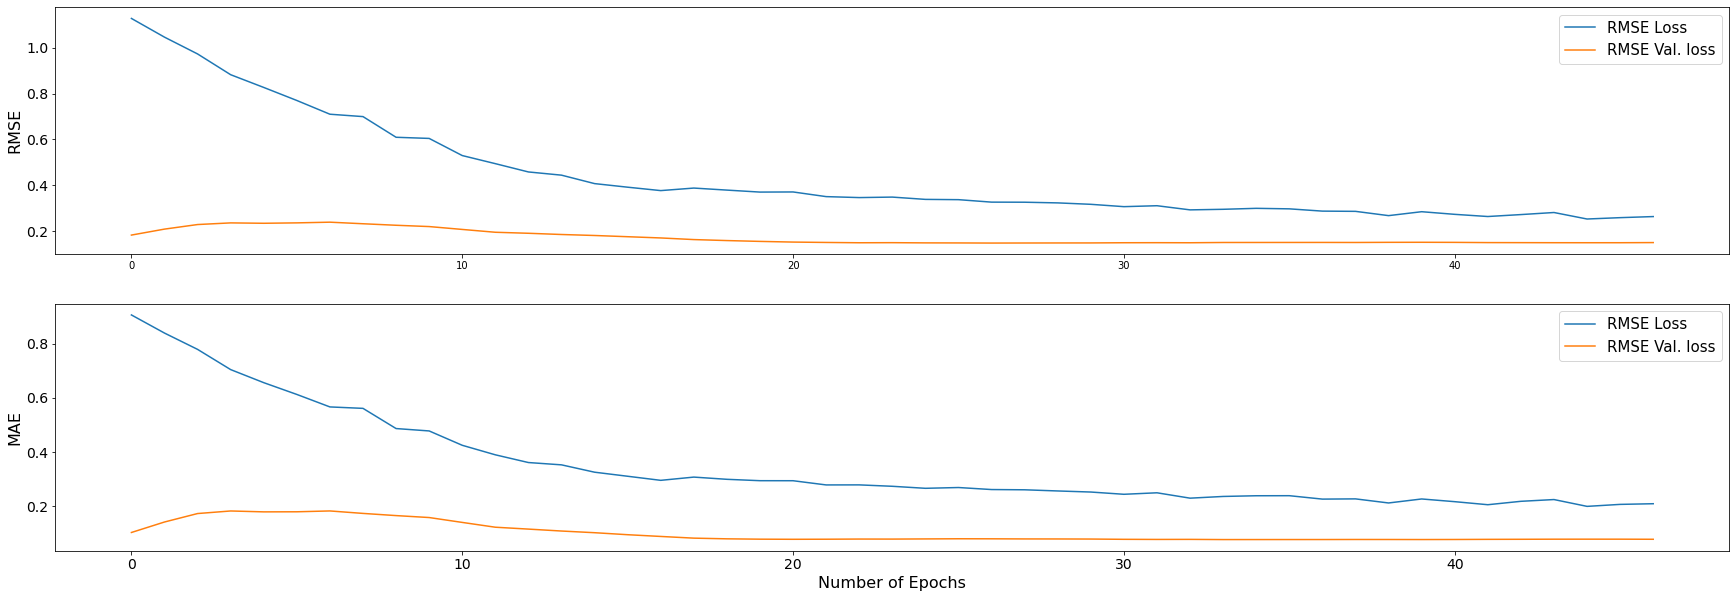

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(deep_convlstm_4_blocks_fits.history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(deep_convlstm_4_blocks_fits.history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(deep_convlstm_4_blocks_fits.history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(deep_convlstm_4_blocks_fits.history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['img_only']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = deep_convlstm_4_blocks.evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
deep_convlstm_4_blocks_test = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.011980889234691858
Test MAE = 0.07628190562129021
Test RMSE = 0.10945686653256416


Train a model with 2 ConvLSTM-CNN blocks only

In [ ]:
#define model that has 2 convlstm-cnn blocks
input = keras.layers.Input(batch_shape=(batch_size, timestep, img_dim[country], img_dim[country]), name='img_input')
x = add_dimension(name='img_add_dim')(input)

x = convlstm_cnn_block(filter_num=4, kernel_num=5, return_sequence=True, name='convlstm_cnn_block1')(x)

x = keras.layers.MaxPooling3D((2, 2, 2), padding='same', name='maxpooling1')(x)

x = convlstm_cnn_block(filter_num=64, kernel_num=3, return_sequence=False, name='convlstm_cnn_block4')(x)

x = keras.layers.GlobalAveragePooling2D(name='globalaveragepooling')(x)
x = keras.layers.Dropout(0.8, name='dropout')(x)
x = keras.layers.Dense(1, name='output')(x)

deep_convlstm_2_blocks = keras.Model(inputs=input, outputs=x, name=key+f'_{country}_convlstm_deep_model_4_blocks')


In [ ]:
#specify training hyperparameter
N_epoch = 100
learn_rate = 1e-4
patience = 20

train_input = X_train[country]['img_only'][key]
train_output = y_train[country][key]

valid_data = (X_valid[country]['img_only'][key], y_valid[country][key])

#set seed
tf.keras.utils.set_random_seed(0)

#compile model
deep_convlstm_2_blocks.compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
                                                loss=keras.losses.MeanSquaredError(),
                                                metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()])

#fit model
deep_convlstm_2_blocks_fits = deep_convlstm_2_blocks.fit(x=train_input, 
                                                         y=train_output, 
                                                         epochs=N_epoch, 
                                                         batch_size=batch_size, 
                                                         verbose=2, 
                                                         validation_data=valid_data, 
                                                         shuffle=False,
                                                         callbacks=[reset_LSTM_state(), earlystopping(patience)])


Epoch 1/100
21/21 - 18s - loss: 1.2172 - mean_absolute_error: 0.8697 - root_mean_squared_error: 1.1033 - val_loss: 0.0345 - val_mean_absolute_error: 0.1133 - val_root_mean_squared_error: 0.1856 - 18s/epoch - 863ms/step
Epoch 2/100
21/21 - 11s - loss: 0.9165 - mean_absolute_error: 0.7534 - root_mean_squared_error: 0.9573 - val_loss: 0.0360 - val_mean_absolute_error: 0.1179 - val_root_mean_squared_error: 0.1897 - 11s/epoch - 543ms/step
Epoch 3/100
21/21 - 11s - loss: 0.5116 - mean_absolute_error: 0.5646 - root_mean_squared_error: 0.7153 - val_loss: 0.0333 - val_mean_absolute_error: 0.1077 - val_root_mean_squared_error: 0.1824 - 11s/epoch - 534ms/step
Epoch 4/100
21/21 - 11s - loss: 0.3642 - mean_absolute_error: 0.4759 - root_mean_squared_error: 0.6035 - val_loss: 0.0272 - val_mean_absolute_error: 0.0852 - val_root_mean_squared_error: 0.1649 - 11s/epoch - 530ms/step
Epoch 5/100
21/21 - 11s - loss: 0.2671 - mean_absolute_error: 0.4013 - root_mean_squared_error: 0.5168 - val_loss: 0.0238 - 

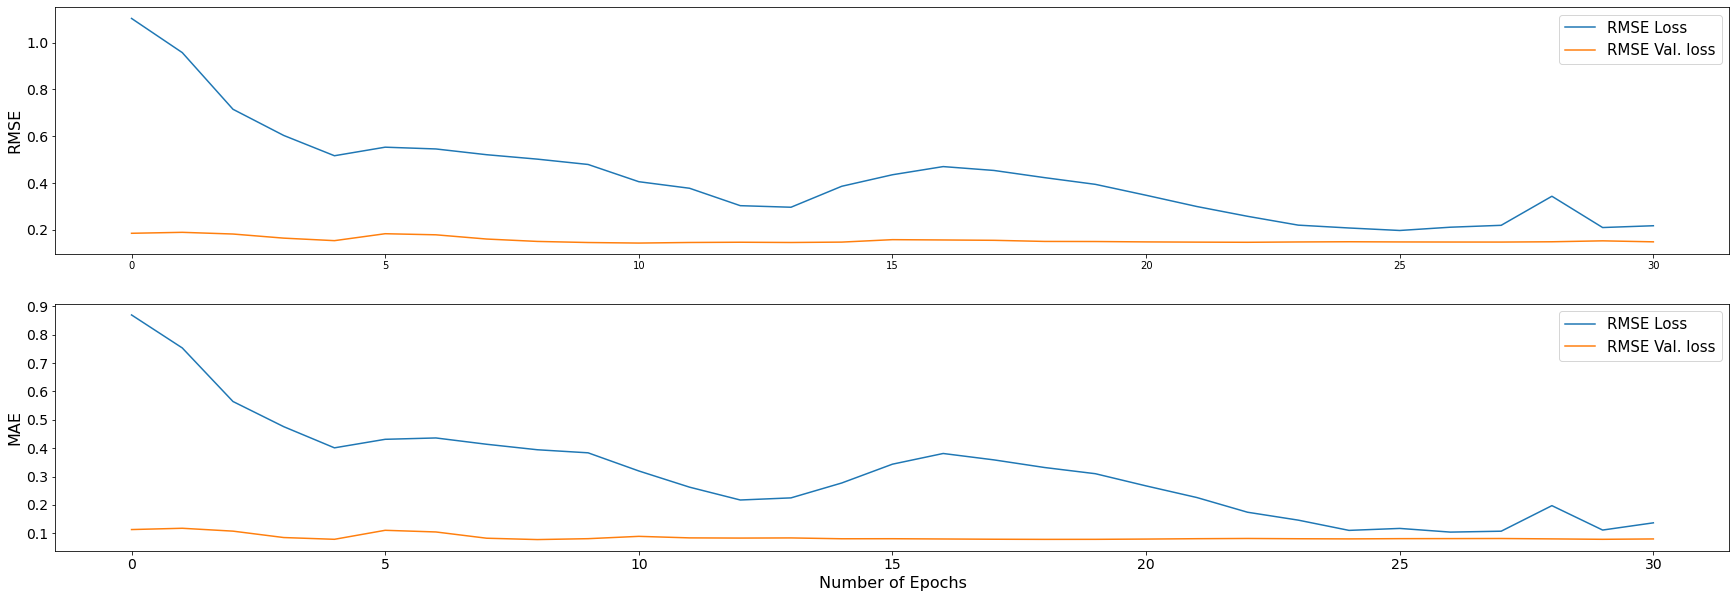

In [ ]:
#plot losses
fig, ax = plt.subplots(2, 1)
ax[0].plot(deep_convlstm_2_blocks_fits.history['root_mean_squared_error'], label='RMSE Loss')
ax[0].plot(deep_convlstm_2_blocks_fits.history['val_root_mean_squared_error'], label='RMSE Val. loss')
ax[0].legend(loc="upper right", prop={'size': 15})
ax[0].set_ylabel("RMSE", fontsize=16)
plt.sca(ax[0])
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)

ax[1].plot(deep_convlstm_2_blocks_fits.history['mean_absolute_error'], label='RMSE Loss')
ax[1].plot(deep_convlstm_2_blocks_fits.history['val_mean_absolute_error'], label='RMSE Val. loss')
ax[1].legend(loc="upper right", prop={'size': 15})

plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of Epochs", fontsize=16)

plt.show()

In [ ]:
#evaluate the model on test data
test_input = X_test[country]['img_only']['3/3']
test_output = y_test[country]['3/3']

#Repeat evaluation to yield average test loss and performacne
trial_N = 50
tf.keras.utils.set_random_seed(0)
avg_test = []

for _ in range(trial_N):
  trial = deep_convlstm_2_blocks.evaluate(test_input, test_output, batch_size=batch_size, verbose=0)
  avg_test.append(trial)

avg_test = np.array(avg_test)
deep_convlstm_2_blocks_test = avg_test.mean(axis=0)

#print results
print(f'Test MSE = {avg_test.mean(axis=0)[0]}')
print(f'Test MAE = {avg_test.mean(axis=0)[1]}')
print(f'Test RMSE = {avg_test.mean(axis=0)[2]}')

Test MSE = 0.010531439818441868
Test MAE = 0.0781401652097702
Test RMSE = 0.10251964211463928


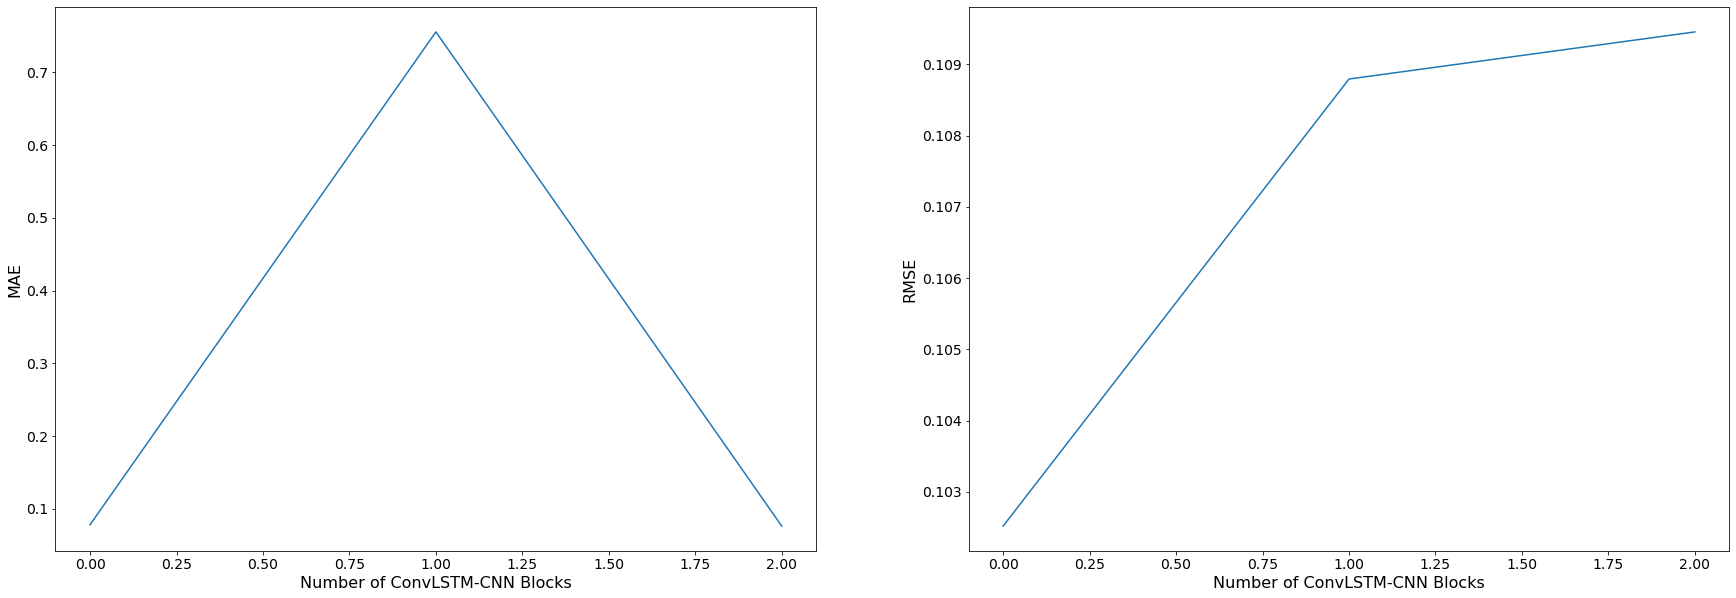

In [ ]:
#plot graph to analyse possible relationship over number of blocks
deep_convlstm_mae = [deep_convlstm_2_blocks_test[1], model_test[country]['3/3']['deep_convlstm'][1], deep_convlstm_4_blocks_test[1]]
deep_convlstm_rmse = [deep_convlstm_2_blocks_test[2], model_test[country]['3/3']['deep_convlstm'][2], deep_convlstm_4_blocks_test[2]]


fig, ax = plt.subplots(1, 2)
ax[0].plot(deep_convlstm_mae, label='MAE')
ax[1].plot(deep_convlstm_rmse, label='RMSE')
ax[0].set_ylabel('MAE')
ax[1].set_ylabel('RMSE')
ax[0].set_xlabel('Number of ConvLSTM-CNN Blocks')
ax[1].set_xlabel('Number of ConvLSTM-CNN Blocks')
plt.sca(ax[0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("MAE", fontsize=16)
plt.xlabel("Number of ConvLSTM-CNN Blocks", fontsize=16)
plt.sca(ax[1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Number of ConvLSTM-CNN Blocks", fontsize=16)
plt.show()




---

